#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
data_train = pd.read_csv(path + '/data01_train.csv')
data_test = pd.read_csv(path + '/data01_test.csv')


In [ ]:
data_train= data_train.drop('subject', axis=1)
data_test= data_test.drop('subject', axis=1)

In [ ]:
data_train.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING


In [ ]:
data_test.shape

(1471, 562)

#### 2) 기본 정보 조회

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [ ]:
data_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
d

In [ ]:
data_train.isna().sum()

,0
tBodyAcc-mean()-X,0
tBodyAcc-mean()-Y,0
tBodyAcc-mean()-Z,0
tBodyAcc-std()-X,0
tBodyAcc-std()-Y,0
...,...
"angle(tBodyGyroJerkMean,gravityMean)",0
"angle(X,gravityMean)",0
"angle(Y,gravityMean)",0
"angle(Z,gravityMean)",0


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


## (0) 정적 동적

In [ ]:
data_train['is_dynamic'] = data_train['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0, 'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
x = data_train.drop(['Activity','is_dynamic'], axis=1)
y = data_train['is_dynamic']

### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
data_train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [ ]:
x = data_train.drop('Activity', axis=1)
# ensemble 모델 상위 10개 feature_importance
# columns = ['tGravityAcc-min()-X', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-energy()-X', 'tGravityAcc-mean()-Y', 'angle(Y,gravityMean)', 'tGravityAcc-mean()-X', 'tGravityAcc-min()-Y', 'angle(X,gravityMean)', 'tGravityAcc-energy()-Y']
# x = x[columns]
y = data_train['Activity']

In [ ]:
x = data_test.drop('Activity', axis=1)
# ensemble 모델 상위 10개 feature_importance
# columns = ['tGravityAcc-min()-X', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-energy()-X', 'tGravityAcc-mean()-Y', 'angle(Y,gravityMean)', 'tGravityAcc-mean()-X', 'tGravityAcc-min()-Y', 'angle(X,gravityMean)', 'tGravityAcc-energy()-Y']
# x = x[columns]
y = data_test['Activity']

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)


In [ ]:
x.shape

(1471, 561)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


In [ ]:
LabelEncoder = LabelEncoder()
y = LabelEncoder.fit_transform(y)

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

In [ ]:
x_train.shape

(4704, 561)

In [ ]:
data_train['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [ ]:
y_train

array([3, 3, 1, ..., 0, 3, 2])

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

## 모델 로딩

In [ ]:
path = '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models'

In [ ]:
# Base_model 로딩
Base_model = joblib.load( '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/Base_model.pkl')

In [ ]:
# model2 로딩
model2 = joblib.load(path + '/model2.pkl')

In [ ]:
path = '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models'
Base_model = joblib.load( '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/Base_model.pkl')
model2 = joblib.load(path + '/model2.pkl')
model3 = joblib.load(path + '/model3.pkl')
model5 = joblib.load(path + '/model5.pkl')

### (1) 모델1

In [ ]:
clear_session()
Base_model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(1, activation='softmax')
])
Base_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11 (44.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Base_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy')


In [ ]:
Base_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2703 - val_loss: 0.0502
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0371 - val_loss: 0.0273
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0162
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0142
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0127
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_loss: 0.0118
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0056 - val_loss: 0.0110
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - val_loss: 0.0106
Epoch 10/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0045 - val_loss: 0.0101
Epoch 11/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0100
Epoch 12/100
147/147 ━━━━━━━━━━━━━━━━━━━━

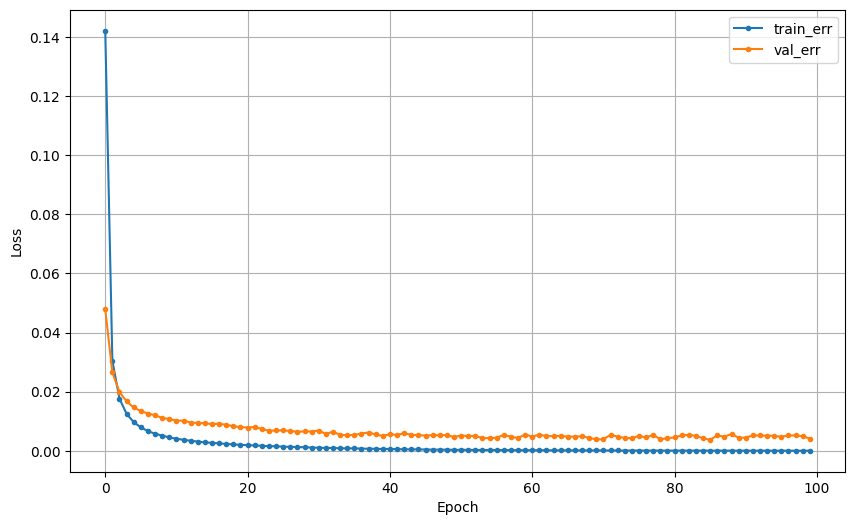

In [ ]:
dl_history_plot(Base_model.history.history)

In [ ]:
y_pred = Base_model.predict(x_val)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

[[654   1]
 [  0 522]]


In [ ]:
## 모델 저장
# joblib.dump(Base_model, 'Base_model.pkl')
joblib.dump(Base_model, '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/base_model_binary.pkl')

['/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/base_model_binary.pkl']

### (2) 모델2

In [ ]:
clear_session()
model2 = Sequential([Input(shape=(x_train.shape[1],)),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(6, activation='softmax')])
                    # Dense(1, activation='sigmoid')])
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,246 (180.65 KB)

 Trainable params: 46,246 (180.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy')

In [ ]:
history2 = model2.fit(x_train, y_train, validation_split = 0.2, verbose =0,epochs=100).history

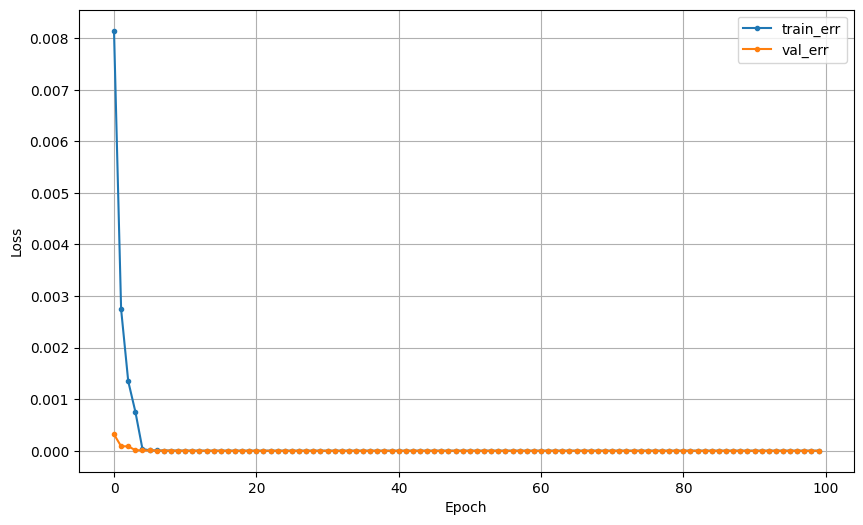

In [ ]:
dl_history_plot(history2)

In [ ]:
y_pred = model2.predict(x_val)
y_pred = np.where(y_pred > 0.5, 1, 0)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

[[654   1]
 [  0 522]]


In [ ]:
#모델저장
# joblib.dump(model2, 'model2.pkl')
joblib.dump(model2, '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model2_binary.pkl')

['/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model2_binary.pkl']

### (3) 모델3

In [ ]:
clear_session()
model3 = Sequential([Input(shape=(x_train.shape[1],)),
                    Dense(512, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                    Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                    #
                    Dense(6, activation='softmax')])
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,182 (961.65 KB)

 Trainable params: 246,182 (961.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy')

In [ ]:
history3 = model3.fit(x_train, y_train, validation_split=0.2, verbose =0,epochs=100).history

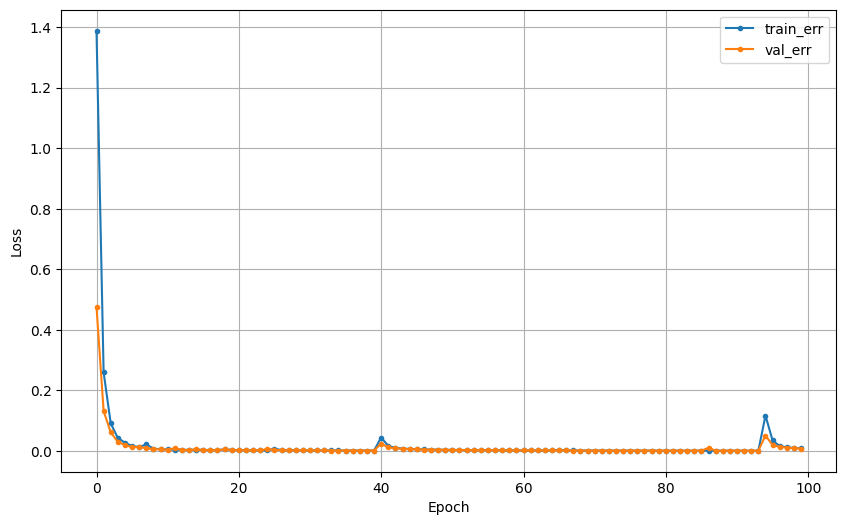

In [ ]:
dl_history_plot(history3)

In [ ]:
y_pred = model3.predict(x_val)
y_pred = np.where(y_pred > 0.5, 1, 0)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

[[653   2]
 [  0 522]]


In [ ]:
joblib.dump(model3, '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model3_binary.pkl')

['/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model3_binary.pkl']

### (4) 모델4

In [ ]:
clear_session()
model4 = Sequential([Input(shape=(x_train.shape[1],)),
                    Dense(512, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                    Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                    Dense(6, activation='softmax')])
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,182 (961.65 KB)

 Trainable params: 246,182 (961.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy')

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # 관찰할 지표
    factor=0.1,          # 학습률을 줄일 비율
    patience=10,         # 'patience' 동안 개선되지 않으면 학습률 조정
    min_lr=0.0001        # 최저 학습률
)

# 모델 학습 시 콜백으로 추가
model4.fit(x_train, y_train, epochs=100,verbose = 0, validation_split = 0.2, callbacks=[reduce_lr])

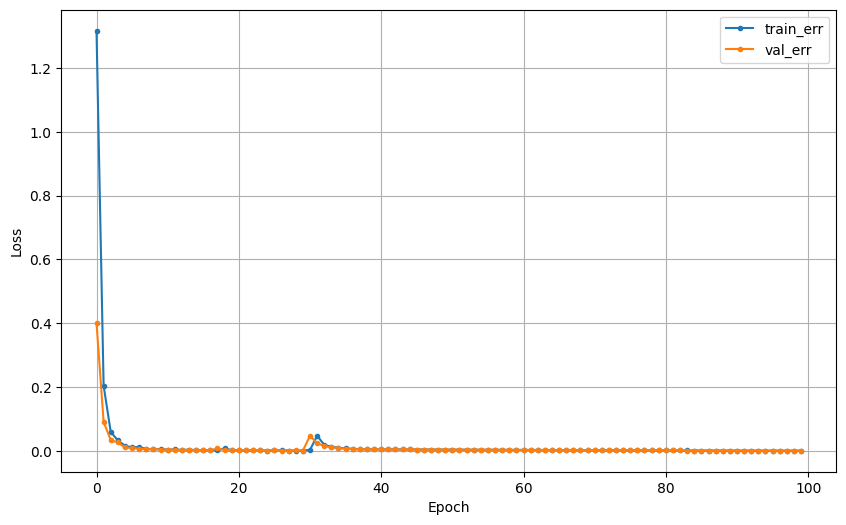

In [ ]:
dl_history_plot(model4.history.history)

In [ ]:
y_pred = model4.predict(x_val)
y_pred = np.where(y_pred > 0.5, 1, 0)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

[[653   2]
 [  0 522]]


In [ ]:
joblib.dump(model4, '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model4_binary.pkl')

['/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model4_binary.pkl']

## (5) 모델 5

In [ ]:
clear_session()
model5 = Sequential([Input(shape=(x_train.shape[1],)),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(6, activation='softmax')])
model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,182 (961.65 KB)

 Trainable params: 246,182 (961.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model5.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy')

In [ ]:
history5 = model5.fit(x_train, y_train, validation_split=0.2, verbose =0,epochs=100).history

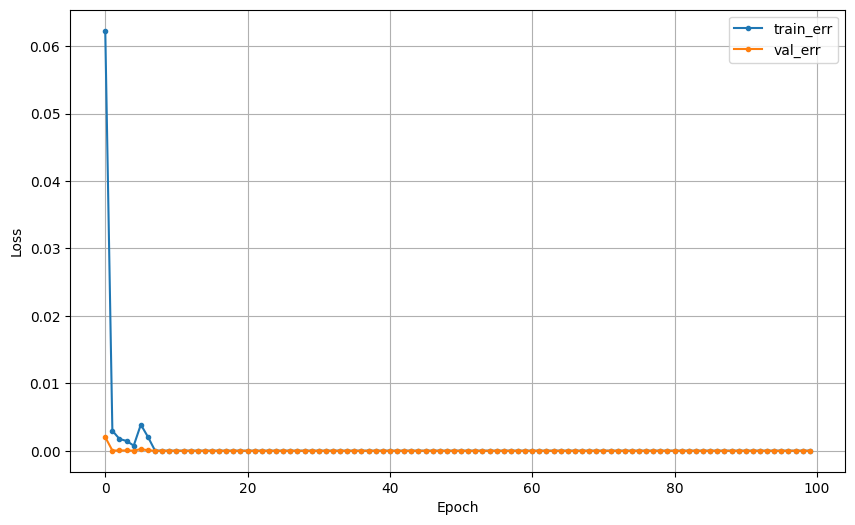

In [ ]:
dl_history_plot(history5)

In [ ]:
y_pred = model5.predict(x_val)
y_pred = np.where(y_pred > 0.5, 1, 0)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

[[653   2]
 [  0 522]]


In [ ]:
joblib.dump(model5, '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model5_binary.pkl')

['/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model5_binary.pkl']

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
y_pred_base = Base_model.predict(x_val)
y_pred_base = np.argmax(y_pred_base, axis=1)
report_base = classification_report(y_val, y_pred_base, output_dict=True)
report_base = pd.DataFrame(report_base)
report_base.drop(index=['support'], inplace=True)
report_base = report_base.transpose()
report_base.drop(index=['accuracy', 'macro avg', 'weighted avg'], axis=1,inplace=True)

report_base

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,precision,recall,f1-score
0,1.000000,1.000000,1.000000
1,0.939698,0.944444,0.942065
2,0.952991,0.948936,0.950959
3,0.989691,1.000000,0.994819
4,1.000000,0.987179,0.993548
5,1.000000,1.000000,1.000000


In [ ]:
y_pred_2 = model2.predict(x_val)
y_pred_2 = np.argmax(y_pred_2, axis=1)
y_pred_3 = model3.predict(x_val)
y_pred_3 = np.argmax(y_pred_3, axis=1)
y_pred_5 = model5.predict(x_val)
y_pred_5 = np.argmax(y_pred_5, axis=1)

report_2 = classification_report(y_val, y_pred_2, output_dict=True)
report_3 = classification_report(y_val, y_pred_3, output_dict=True)
report_5 = classification_report(y_val, y_pred_5, output_dict=True)

report_2 = pd.DataFrame(report_2)
report_3 = pd.DataFrame(report_3)
report_5 = pd.DataFrame(report_5)

# report_2.drop(columns=['support'], inplace=True)
# report_3.drop(columns=['support'], inplace=True)
# report_5.drop(columns=['support'], inplace=True)

# report_2 = report_2.transpose()
# report_3 = report_3.transpose()
# report_5 = report_5.transpose()



37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
report_2.drop(index=['support'], axis=1,inplace=True)
report_3.drop(index=['support'],axis=1, inplace=True)
report_5.drop(index=['support'], axis=1,inplace=True)


In [ ]:
report_2 = report_2.transpose()
report_3 = report_3.transpose()
report_5 = report_5.transpose()


In [ ]:
report_2.drop(index=['accuracy', 'macro avg', 'weighted avg'], axis=1,inplace=True)
report_3.drop(index=['accuracy', 'macro avg', 'weighted avg'],axis=1, inplace=True)
report_5.drop(index=['accuracy', 'macro avg', 'weighted avg'], axis=1,inplace=True)

In [ ]:
report_2.columns

Index(['precision', 'recall', 'f1-score'], dtype='object')

In [ ]:
report_combined_precision = pd.concat([report_2[['precision']].add_suffix('_layer5'),
                             report_3[['precision']].add_suffix('_layer7_dropout'),
                             report_5[['precision']].add_suffix('_layer7_no_dropout')], axis=1, join='inner')
report_combined_recall = pd.concat([report_2[['recall']].add_suffix('_layer5'),
                             report_3[['recall']].add_suffix('_layer7_dropout'),
                             report_5[['recall']].add_suffix('_layer7_no_dropout')], axis=1, join='inner')
report_combined_f1_score = pd.concat([report_2[['f1-score']].add_suffix('_layer5'),
                             report_3[['f1-score']].add_suffix('_layer7_dropout'),
                             report_5[['f1-score']].add_suffix('_layer7_no_dropout')], axis=1, join='inner')
report_combineds = [(report_combined_precision, 'precision'),(report_combined_recall,'recall'),(report_combined_f1_score,'f1-score')]
print(report_combined_precision)

   precision_layer5  precision_layer7_dropout  precision_layer7_no_dropout
0          0.995495                  1.000000                     1.000000
1          0.974093                  0.950249                     0.928910
2          0.962343                  0.969828                     0.990991
3          1.000000                  0.994819                     0.994819
4          1.000000                  1.000000                     1.000000
5          0.994286                  1.000000                     1.000000


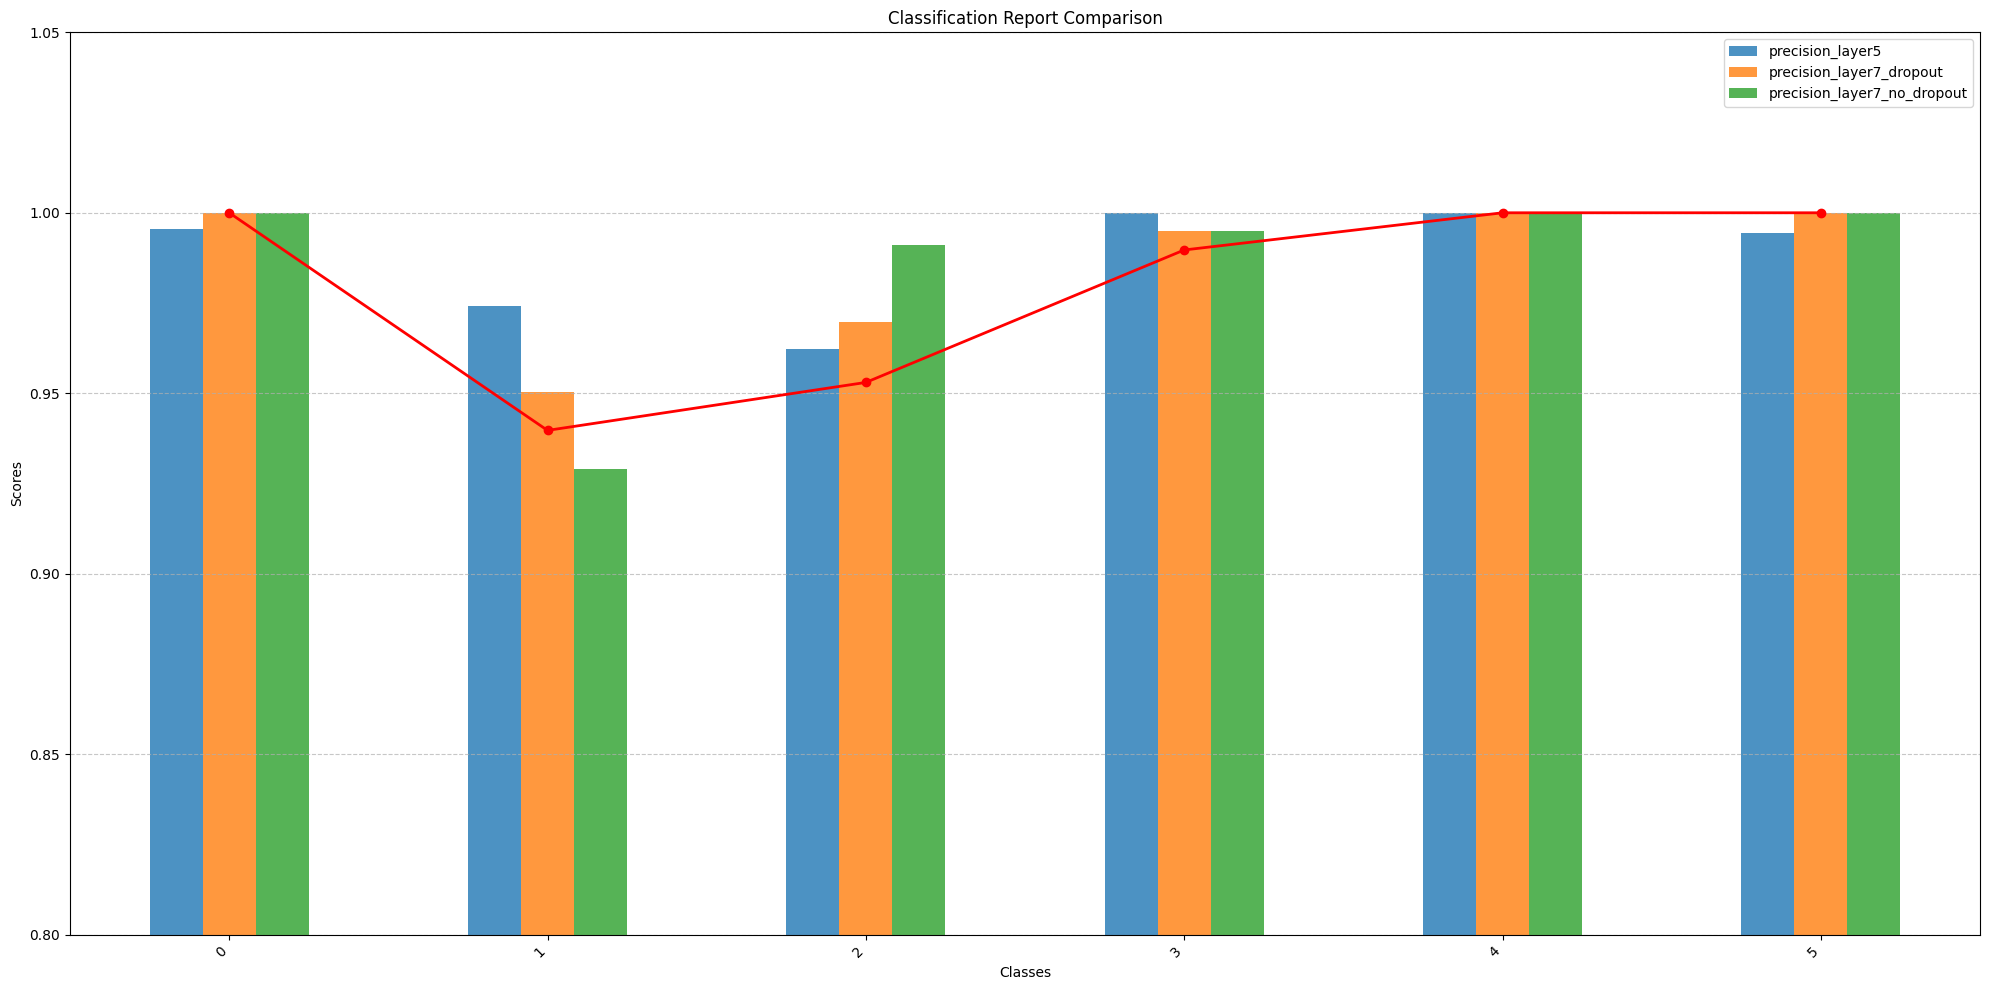

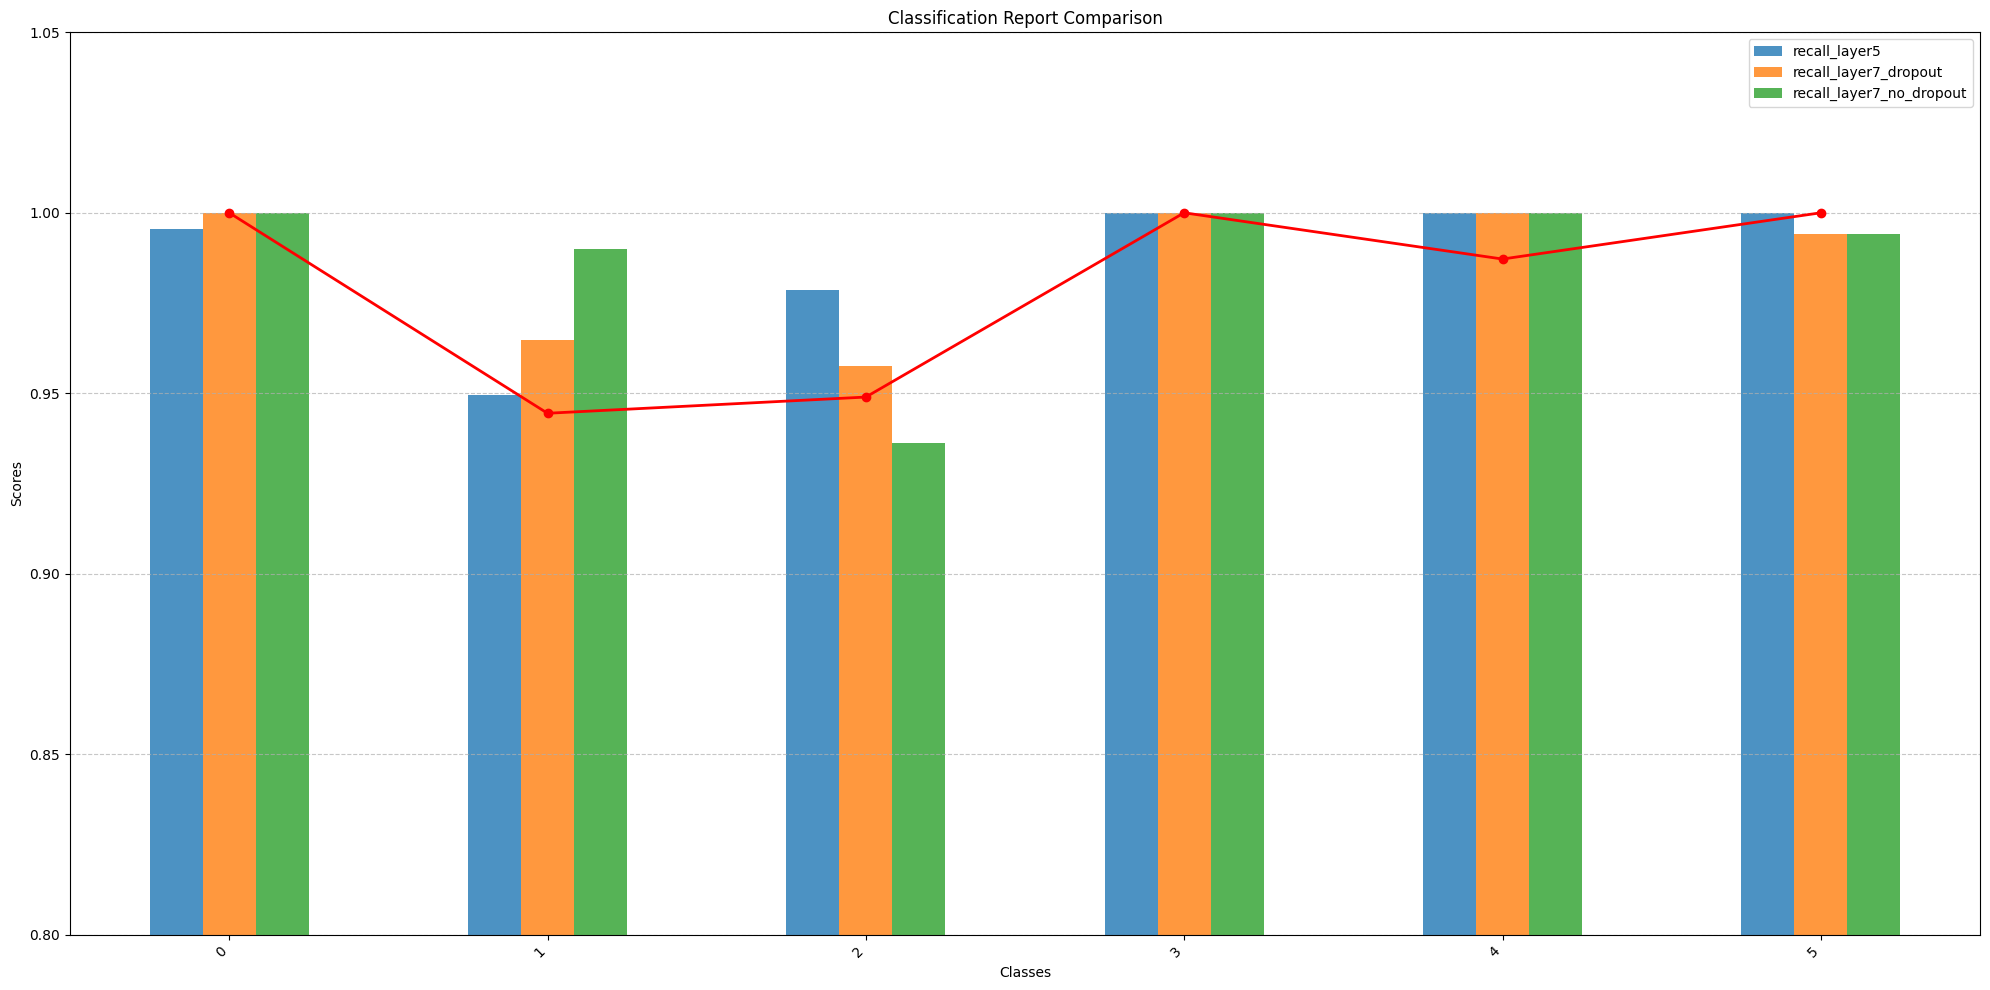

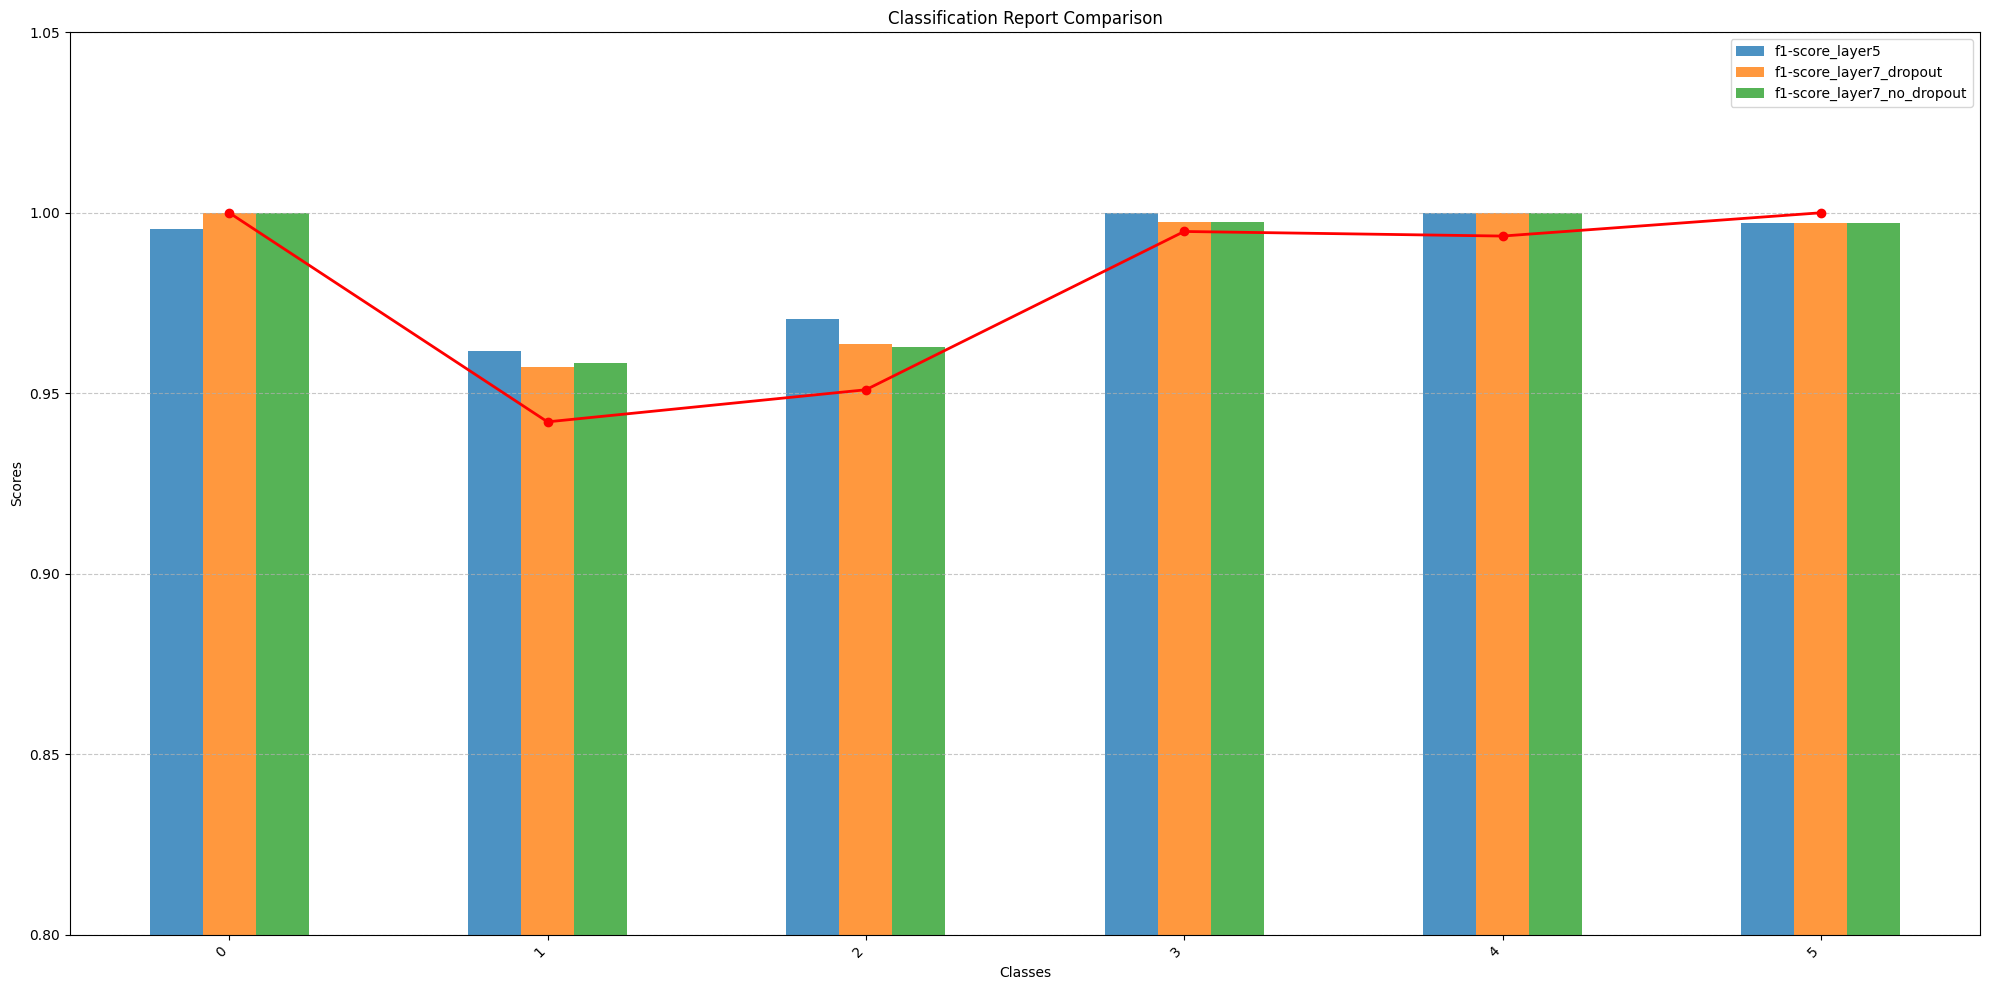

In [ ]:
for report_combine, name in report_combineds:
  # Y축 범위를 데이터의 최솟값과 최댓값으로 설정
  # Y축 범위를 0.8부터 최댓값으로 설정
  y_min = 0.8
  y_max = report_combine.max().max() + 0.05  # 데이터의 최댓값보다 약간 크게 설정

  # 막대 그래프 그리기
  report_combine.plot(kind='bar', figsize=(20, 10), alpha=0.8)  # 막대 투명도 조절
  plt.title('Classification Report Comparison')
  plt.xlabel('Classes')
  plt.ylabel('Scores')
  plt.xticks(rotation=45, ha='right')
  plt.ylim(y_min, y_max)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  x_positions = range(len(report_combine.index))  # 각 클래스의 x 위치
  plt.plot(x_positions, report_base[name], color='red', marker='o', linestyle='-', linewidth=2, label='Recall Base')

  plt.tight_layout()
  plt.show()

In [ ]:
def compare_classification_reports(models, x_val, y_val, model_names=None):
    """
    Compare classification reports of multiple models and plot precision, recall, and F1-score for each class.

    Parameters:
    - models: list of models
    - x_val: validation data features
    - y_val: validation data labels
    - model_names: list of model names (optional), default is ['Model 0', 'Model 1', ...]
    """

    # If model names are not provided, create default names
    if model_names is None:
        model_names = [f'Model {i}' for i in range(len(models))]
    else:
        if len(model_names) != len(models):
            raise ValueError("Length of model_names must match length of models")

    # First model is the base model
    base_model = models[0]
    y_pred_base = base_model.predict(x_val)
    y_pred_base = np.argmax(y_pred_base, axis=1)
    report_base = classification_report(y_val, y_pred_base, output_dict=True)
    report_base = pd.DataFrame(report_base)

    report_base.drop(columns=['accuracy', 'macro avg', 'weighted avg'],axis=1, inplace=True)
    report_base.drop(index=['support'], inplace=True)
    report_base = report_base.transpose()

    # Collect reports for other models
    reports = []
    for model in models[1:]:
        y_pred = model.predict(x_val)
        y_pred = np.argmax(y_pred, axis=1)
        report = classification_report(y_val, y_pred, output_dict=True)
        report = pd.DataFrame(report).transpose()
        print(report.columns)

        report.drop(index=['accuracy', 'macro avg', 'weighted avg'],axis=1, inplace=True)
        report.drop(columns=['support'], inplace=True)
        # report = report.transpose()
        reports.append(report)

    # Build combined dataframes for precision, recall, f1-score
    metrics = ['precision', 'recall', 'f1-score']
    report_combineds = {}
    for metric in metrics:
        dfs = []
        for i, report in enumerate(reports):

            df_metric = report[[metric]].rename(columns={metric: f'{metric}_{model_names[i+1]}'})
            dfs.append(df_metric)
        # Combine the dataframes
        report_combined = pd.concat(dfs, axis=1, join='inner')
        report_combineds[metric] = report_combined

    # Now plot the combined dataframes, overplotting the base model's values
    for metric in metrics:
        report_combine = report_combineds[metric]
        # Y-axis range
        y_min = 0.8
        y_max = report_combine.max().max() + 0.05  # Slightly higher than max value

        # Plot bar graph
        ax = report_combine.plot(kind='bar', figsize=(20, 10), alpha=0.8)
        plt.title(f'Classification Report Comparison - {metric.capitalize()}')
        plt.xlabel('Classes')
        plt.ylabel('Scores')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(y_min, y_max)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Plot base model's metric
        x_positions = range(len(report_combine.index))
        base_values = report_base.loc[report_combine.index, metric]
        plt.plot(x_positions, base_values, color='red', marker='o', linestyle='-', linewidth=2, label=f'{metric.capitalize()} {model_names[0]}')
        plt.legend(fontsize=20, loc='lower right')
        plt.tight_layout()
        plt.show()


In [ ]:
def compare_classification_reports(models, x_val, y_val, model_names=None, cut_y=False, binary= False):
    """
    Compare classification reports of multiple models and plot accuracy, precision, recall, and F1-score.

    Parameters:
    - models: list of models
    - x_val: validation data features
    - y_val: validation data labels
    - model_names: list of model names (optional), default is ['Model 0', 'Model 1', ...]
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    import matplotlib

    # If model names are not provided, create default names
    if model_names is None:
        model_names = [f'Model {i}' for i in range(len(models))]
    else:
        if len(model_names) != len(models):
            raise ValueError("Length of model_names must match length of models")

    accuracies = []
    reports = []

    # Initialize colors for models
    cmap = matplotlib.cm.get_cmap('tab10')  # Default colormap
    num_colors = cmap.N
    if len(models) > num_colors:
        cmap = matplotlib.cm.get_cmap('tab20')  # Use a larger colormap if needed
    colors = [cmap(i) for i in range(len(models))]
    model_colors = dict(zip(model_names, colors))

    # Process each model
    for i, model in enumerate(models):
        y_pred = model.predict(x_val)
        if binary:
          y_pred = np.where(y_pred > 0.5, 1, 0)
        else:
          y_pred = np.argmax(y_pred, axis=1)
        report = classification_report(y_val, y_pred, output_dict=True)
        accuracy = report['accuracy']
        accuracies.append(accuracy)
        report_df = pd.DataFrame(report).transpose()
        # Remove unnecessary rows and columns
        report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)
        report_df.drop(columns=['support'], inplace=True)
        reports.append(report_df)

    # Create the accuracy bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, accuracies, color=[model_colors[name] for name in model_names])
    plt.title('Model Accuracies', fontsize=16)
    plt.xlabel('Models', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    if cut_y :
      plt.ylim(0.8, 1.0)  # Adjust the y-axis range as needed
    # Annotate each bar with the accuracy value
    for bar, acc in zip(bars, accuracies):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{acc:.3f}', ha='center', va='bottom', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Build combined dataframes for precision, recall, f1-score
    metrics = ['precision', 'recall', 'f1-score']
    report_combineds = {}
    for metric in metrics:
        dfs = []
        for i, report in enumerate(reports[1:]):  # Skip the base model
            df_metric = report[[metric]].rename(columns={metric: f'{metric}_{model_names[i+1]}'})
            dfs.append(df_metric)
        # Combine the dataframes
        report_combined = pd.concat(dfs, axis=1, join='inner')
        report_combineds[metric] = report_combined

    # Now plot the combined dataframes, overplotting the base model's values
    base_report = reports[0]
    for metric in metrics:
        report_combine = report_combineds[metric]
        # # Y-axis range
        # y_min = 0.8
        # y_max = min(report_combine.max().max() + 0.05, 1.0)  # Ensure y_max does not exceed 1.0

        # Get colors for the models (excluding the base model)
        column_colors = []
        for col in report_combine.columns:
            # Extract model name from column name
            model_name = '_'.join(col.split('_')[1:])
            color = model_colors.get(model_name, 'blue')
            column_colors.append(color)

        # Plot bar graph
        y_min = 0.8
        y_max = report_combine.max().max() + 0.05  # Slightly higher than max value
        ax = report_combine.plot(kind='bar', figsize=(20, 10), alpha=0.8, color=column_colors)
        plt.title(f'Classification Report Comparison - {metric.capitalize()}', fontsize=16)
        plt.xlabel('Classes', fontsize=14)
        plt.ylabel('Scores', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)
        if cut_y :
            plt.ylim(y_min, y_max)

        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Plot base model's metric
        x_positions = range(len(report_combine.index))
        base_values = base_report.loc[report_combine.index, metric]
        plt.plot(x_positions, base_values, color=model_colors[model_names[0]], marker='o', linestyle='-', linewidth=2, label=f'{metric.capitalize()} {model_names[0]}')
        # Annotate each bar with metric values

        for i, (pos, values) in enumerate(zip(x_positions, report_combine.values.T)):
          for j, val in enumerate(values):
              # 각 막대의 중앙에 값 표시
              ax.text(j + (i - len(values) / 2) * 0.1, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=10)
        plt.legend(fontsize=12, loc='lower right')
        plt.tight_layout()
        plt.show()


 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

<ipython-input-306-54a0ca3c6bee>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('tab10')  # Default colormap


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 1/37 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


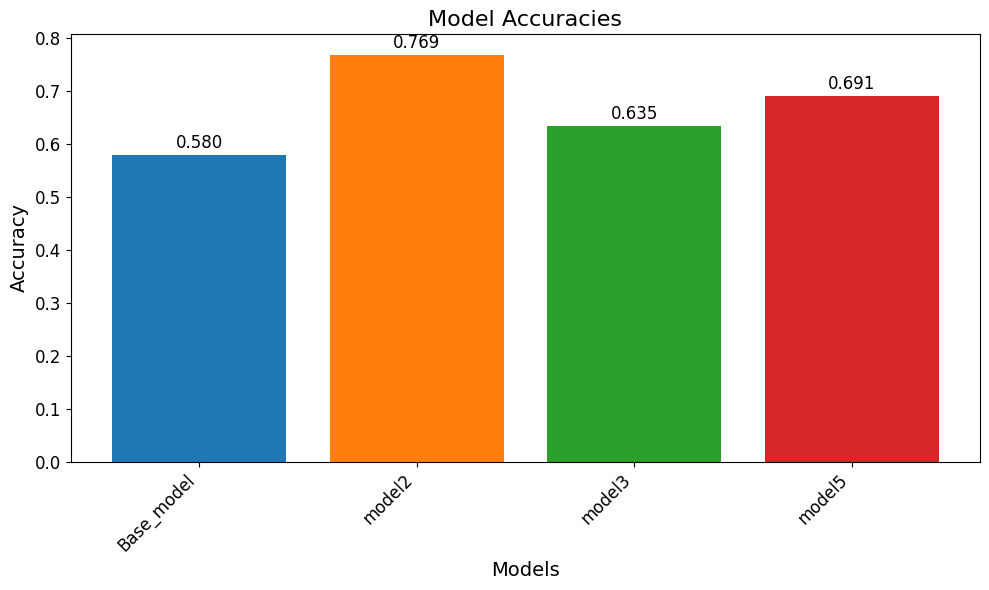

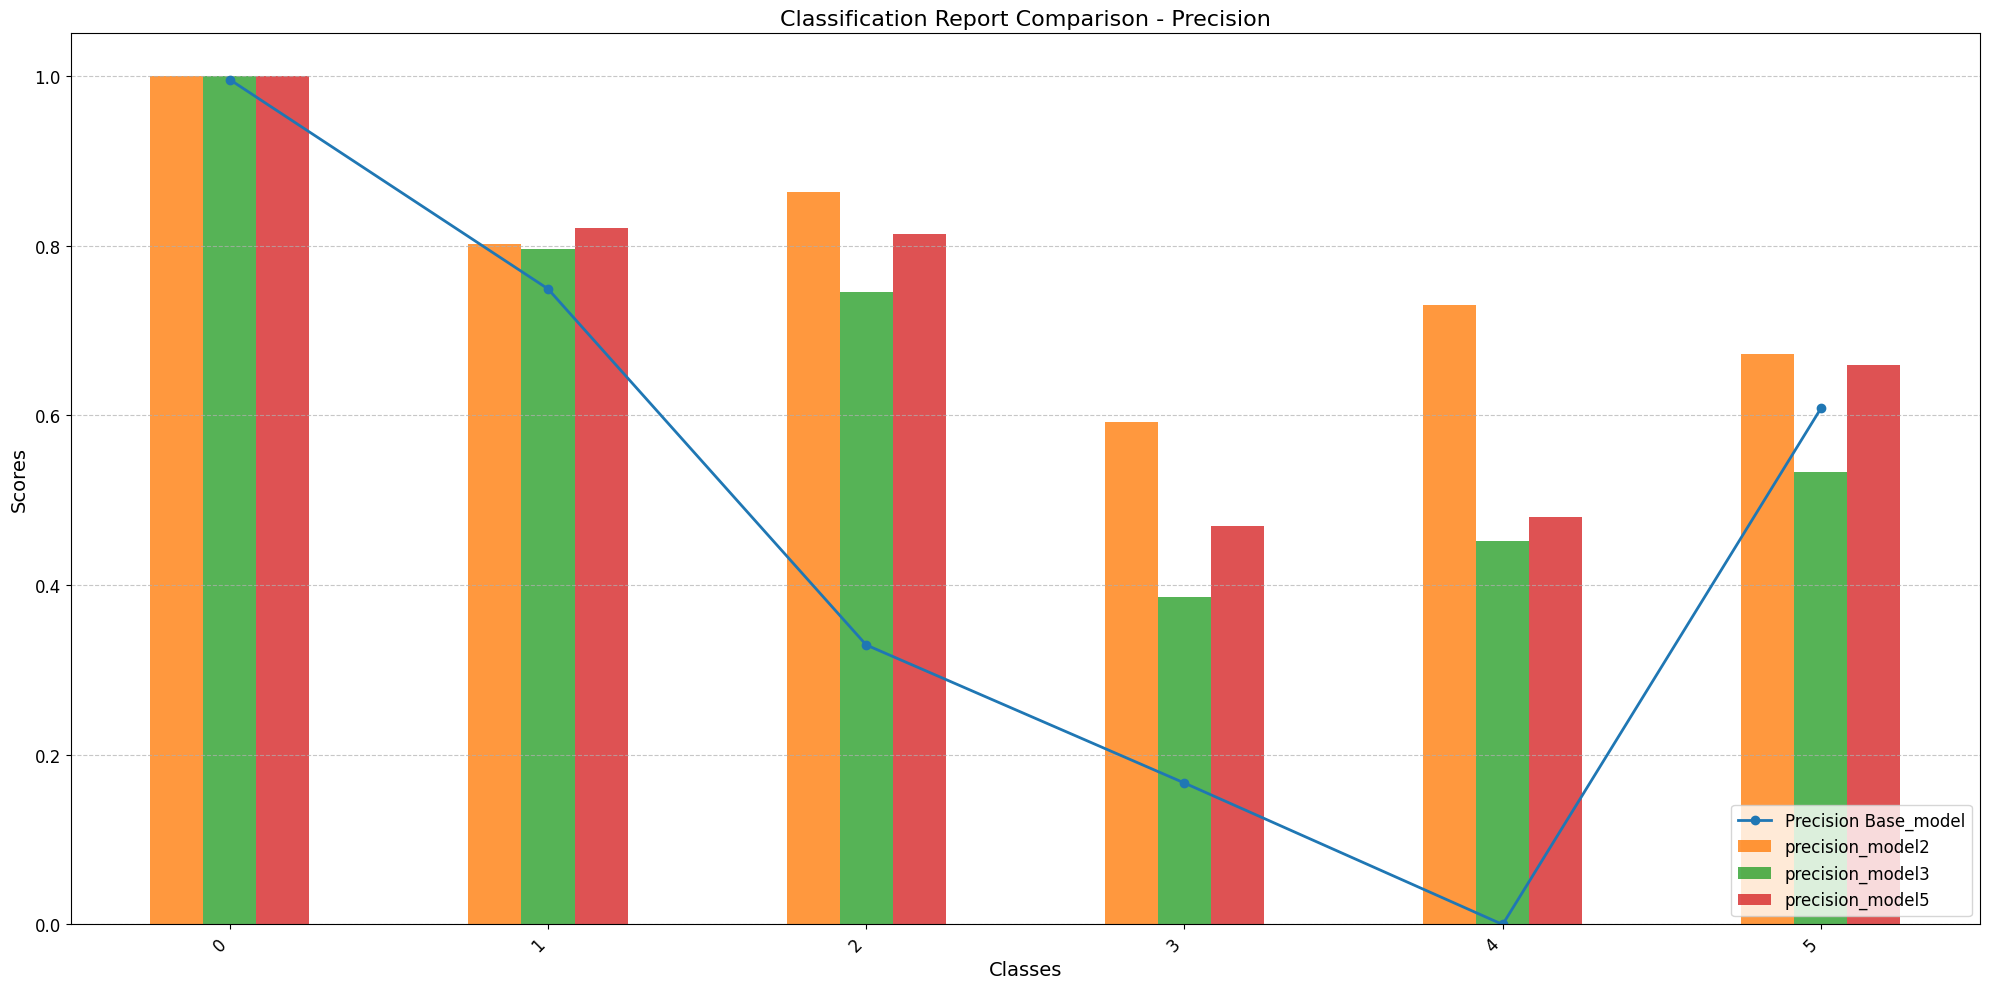

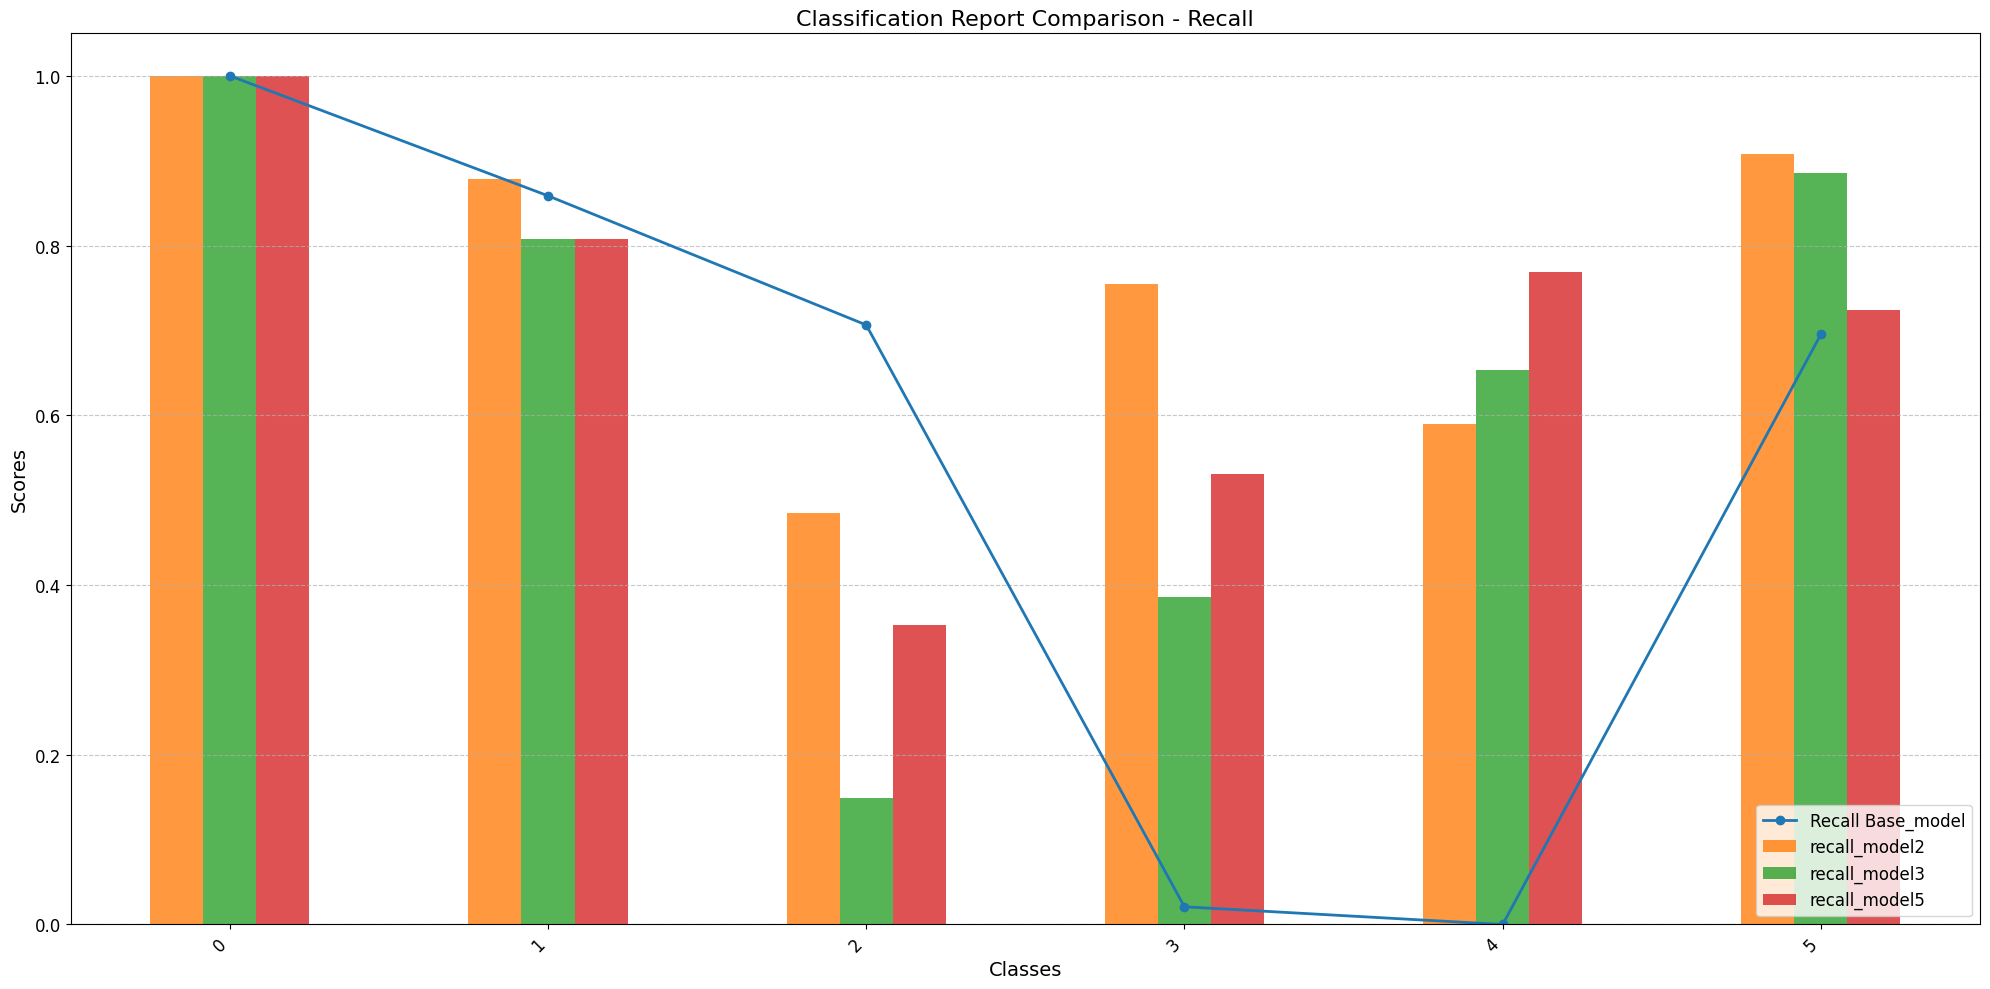

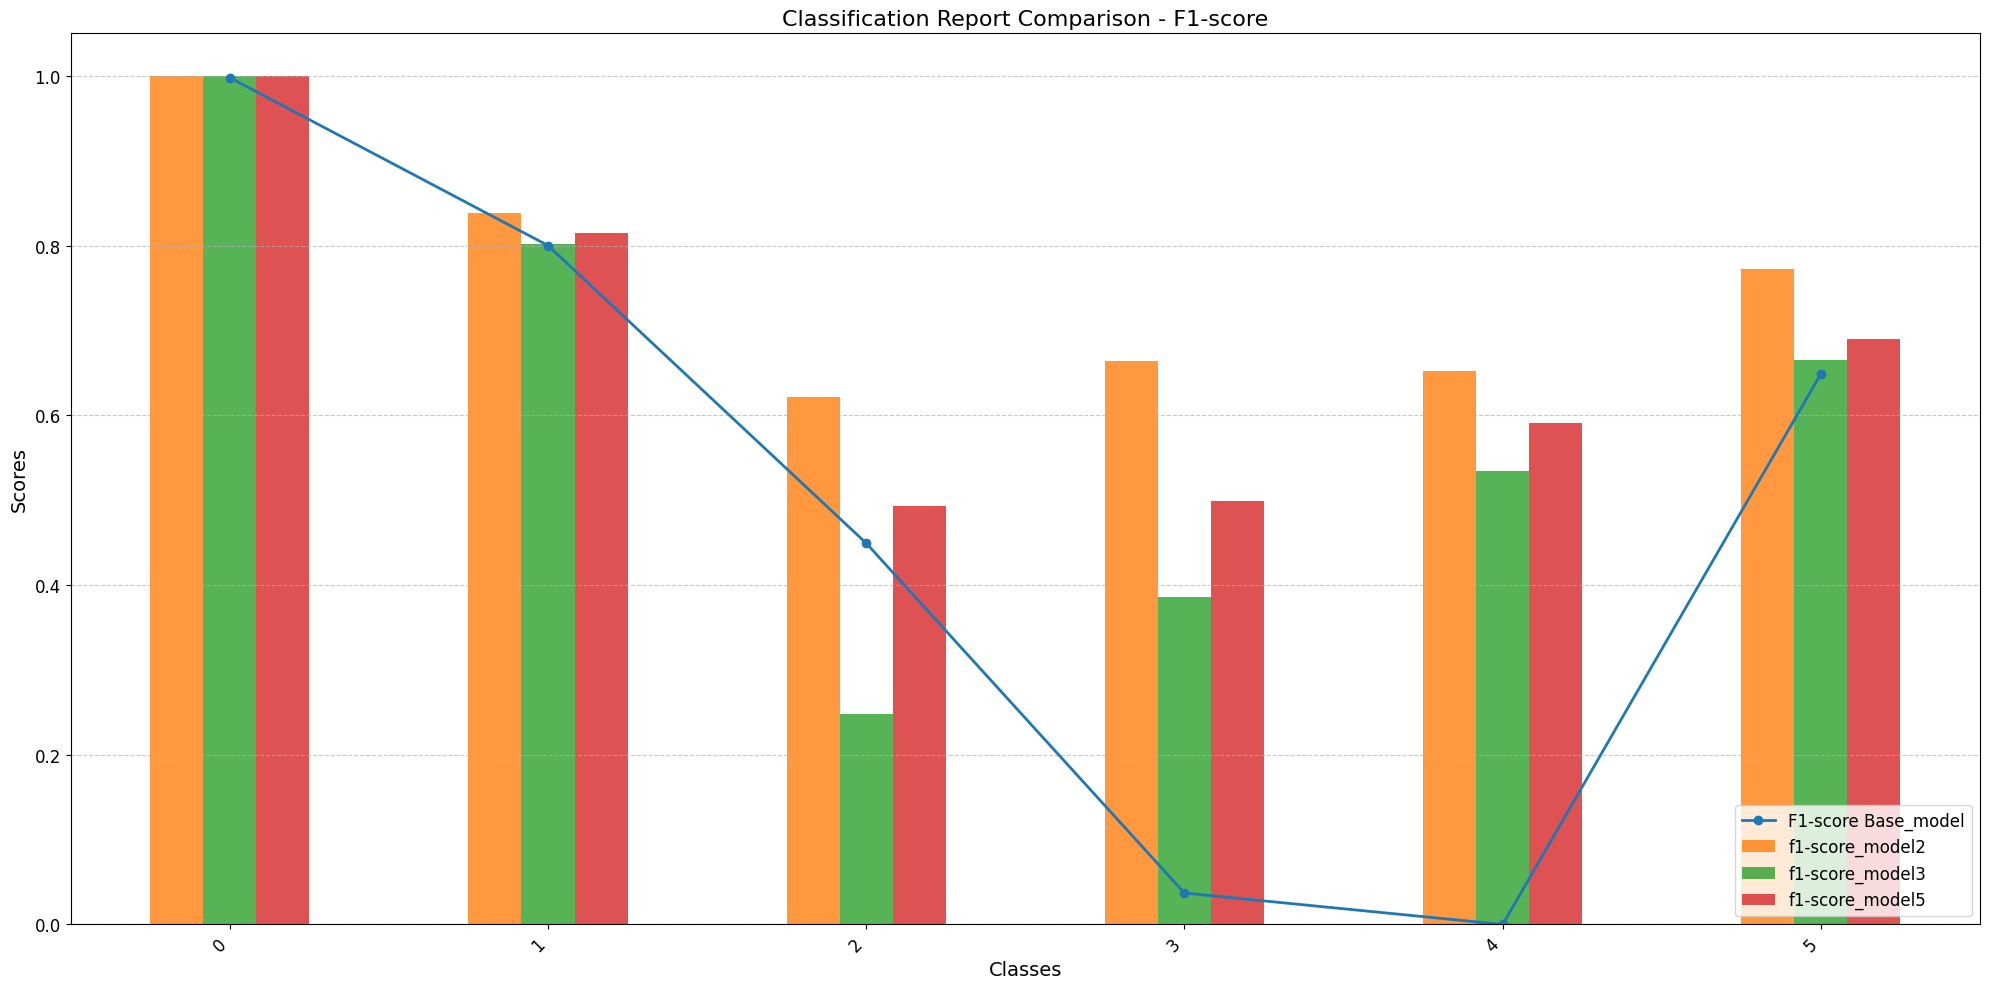

In [ ]:
models = [Base_model, model2, model3, model5]
model_names = ['Base_model', 'model2', 'model3', 'model5']
compare_classification_reports(models, x_val, y_val, model_names, cut_y=F)

In [ ]:
x_train.shape


(4704, 561)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<ipython-input-522-614c79d694af>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('tab10')  # Default colormap


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


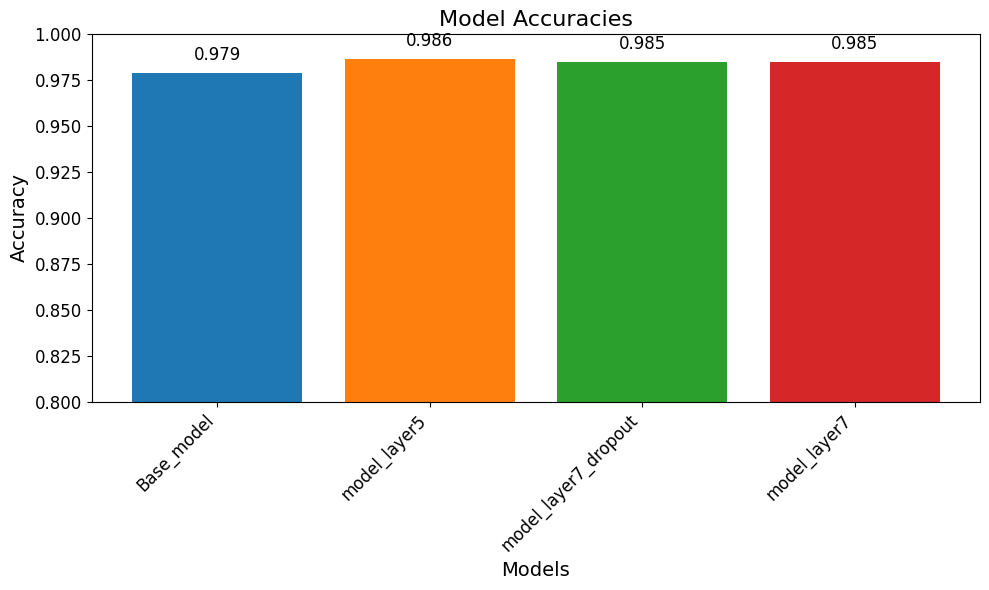

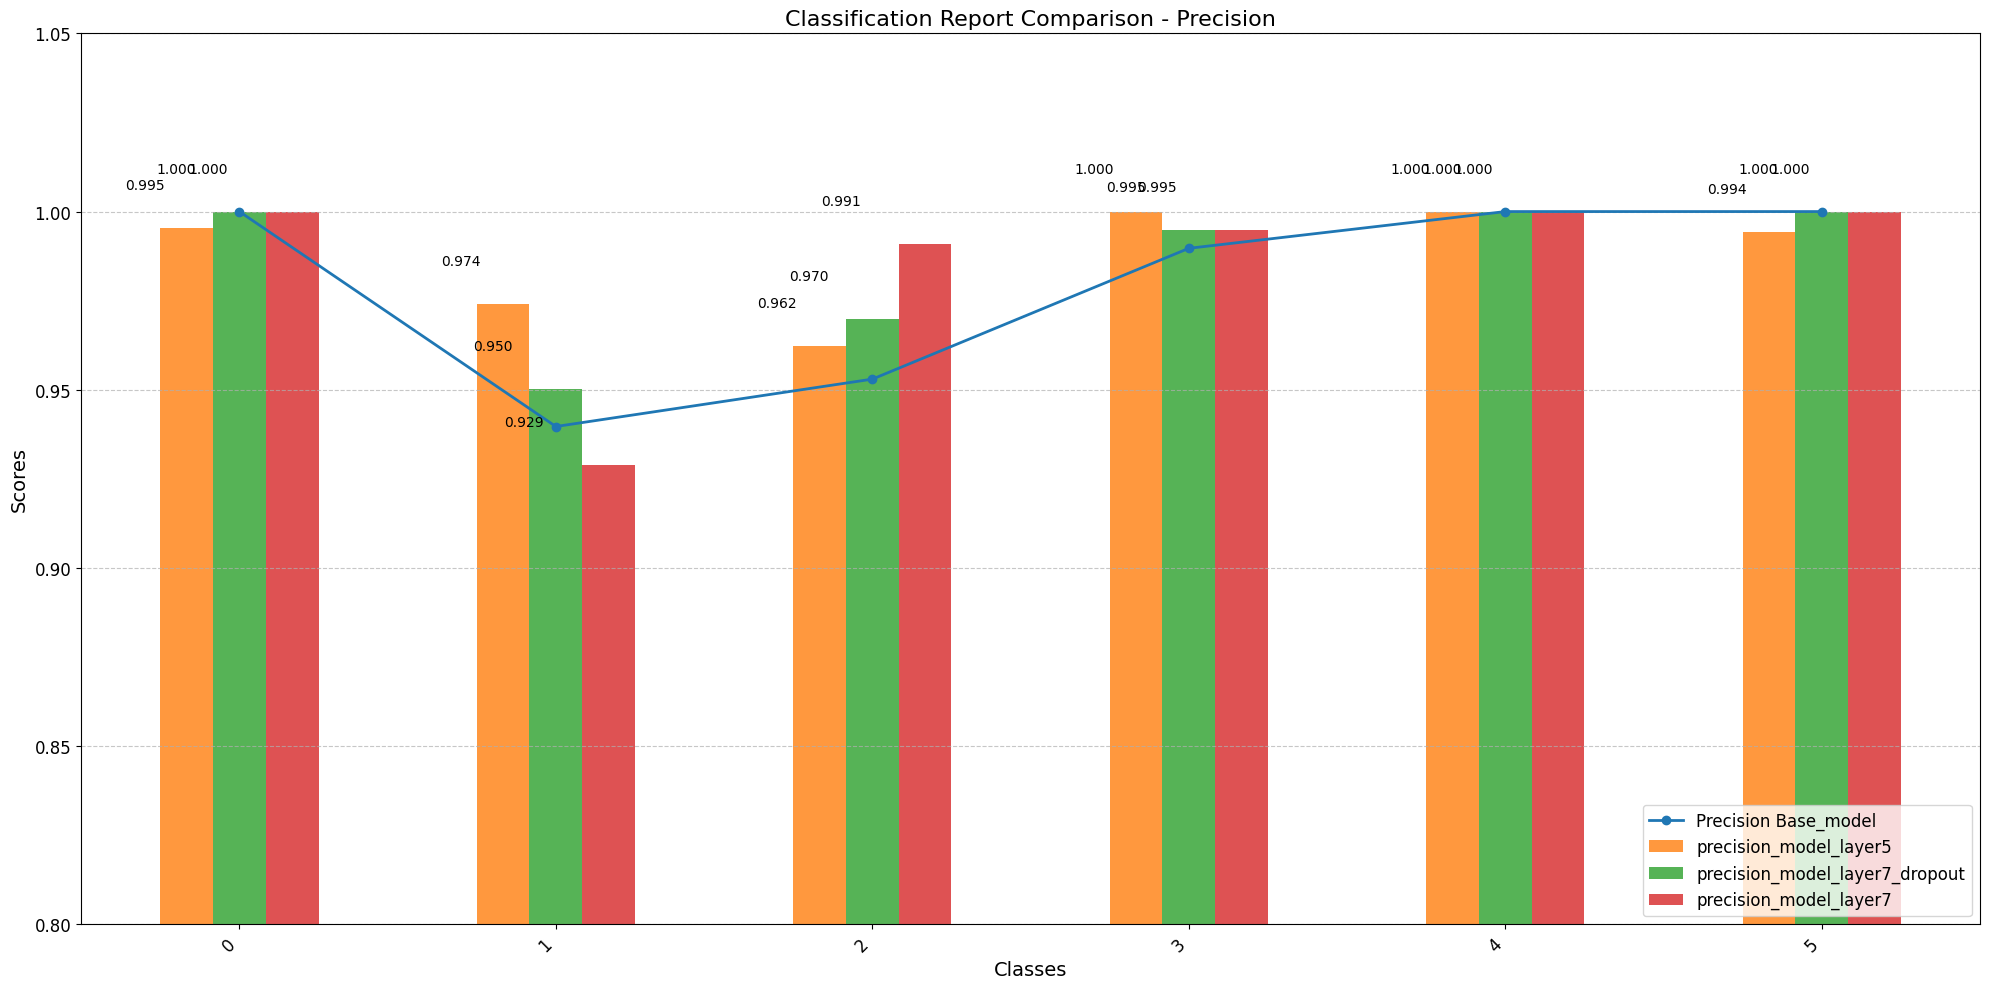

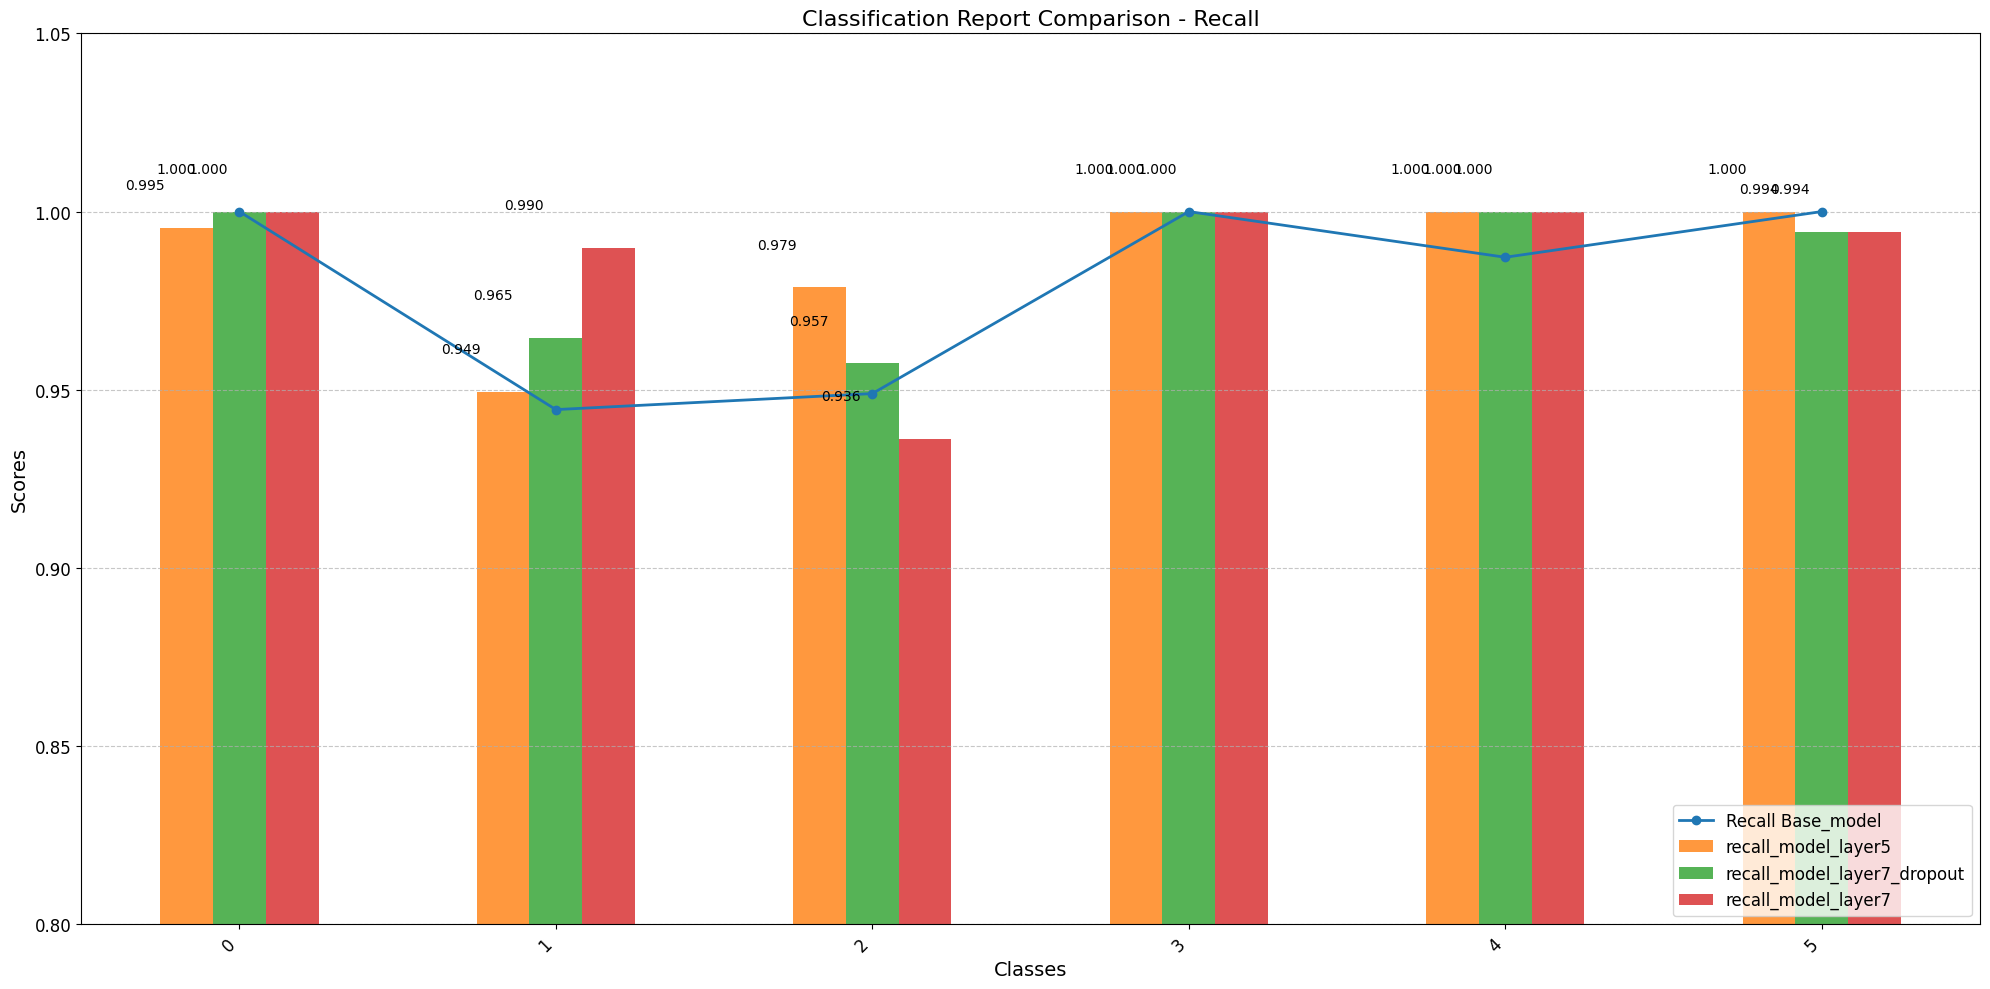

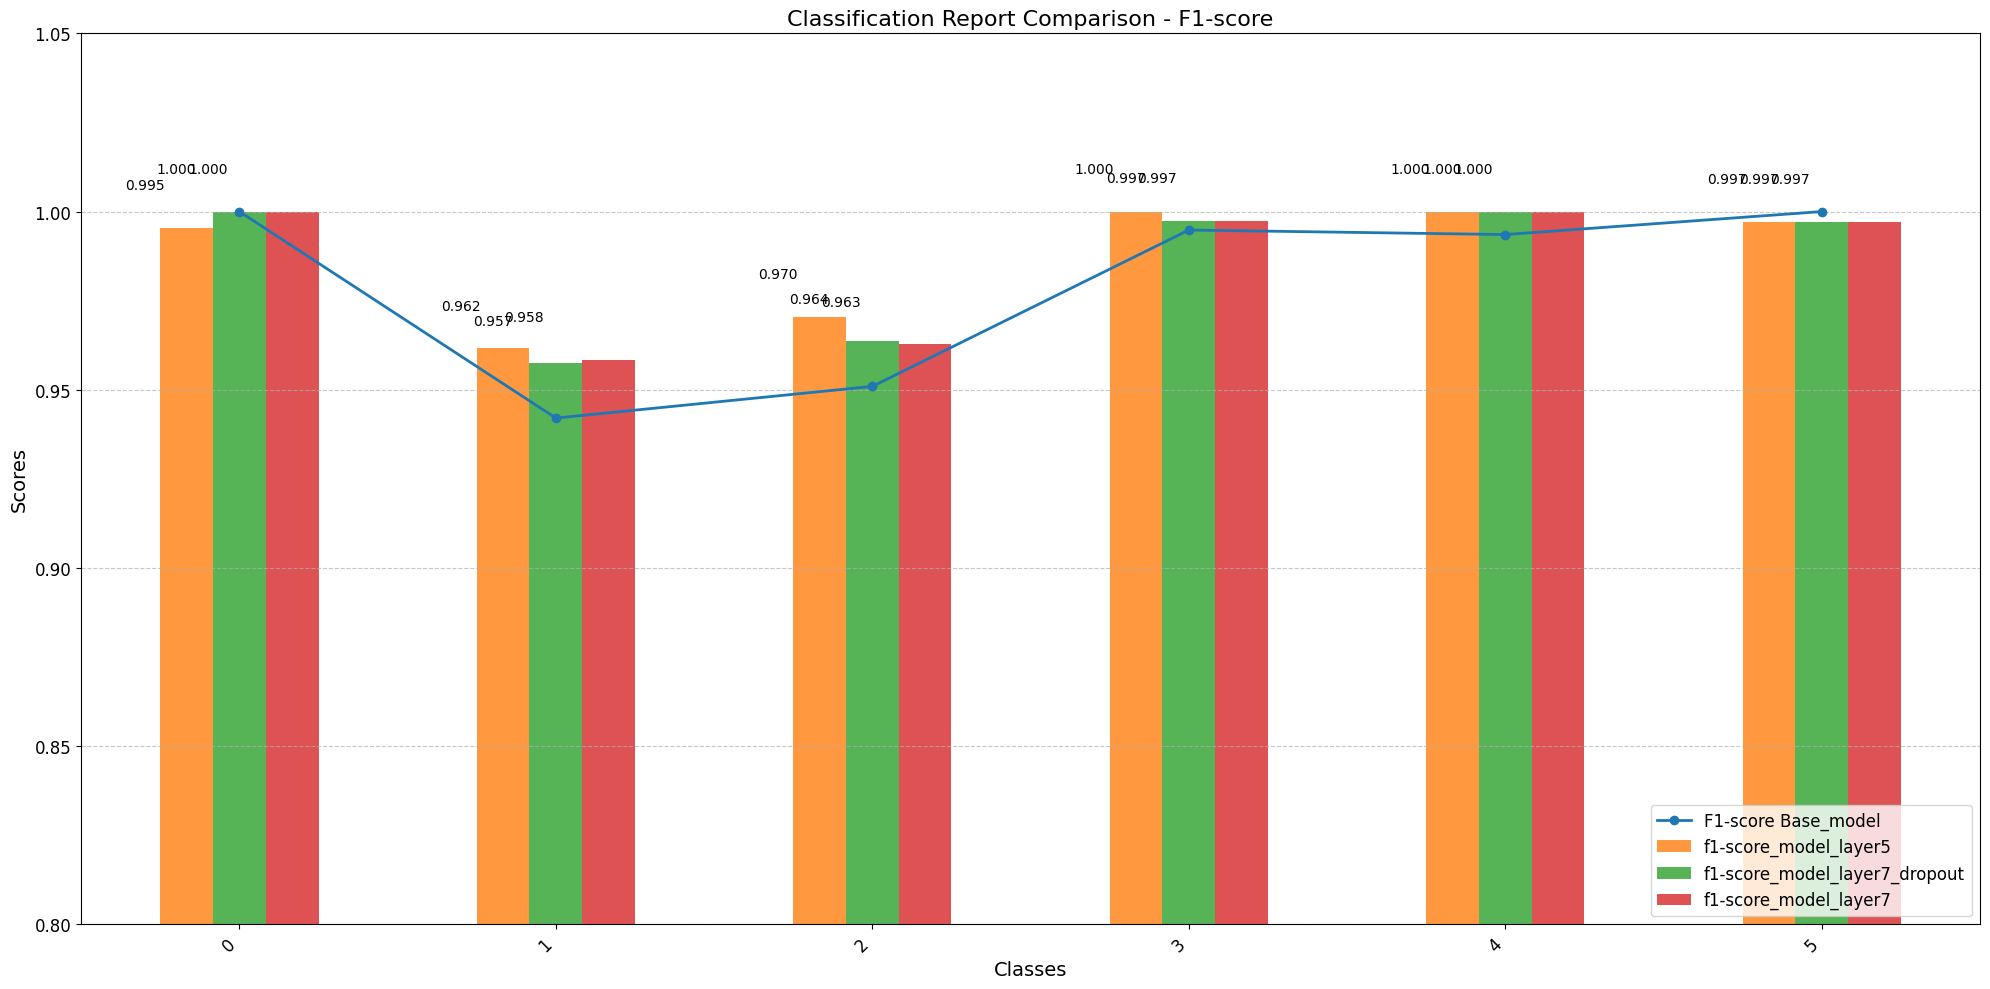

In [ ]:
models = [Base_model, model2, model3, model5]
model_names = ['Base_model', 'model_layer5', 'model_layer7_dropout', 'model_layer7']
compare_classification_reports(models, x_val, y_val,model_names, cut_y=True)

In [ ]:
models = [Base_model, model2, model3, model5]
model_names = ['Base_model', 'model_layer5_binary', 'model_layer7_dropout_binary', 'model_layer7_binary']
compare_classification_reports(models, x_val, y_val,model_names, binary=True, cut_y=True)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<ipython-input-522-614c79d694af>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('tab10')  # Default colormap


ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [ ]:
path = '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models'
Base_model = joblib.load( '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/base_model_feature_10.pkl')
model2 = joblib.load(path + '/model2_feature_10.pkl')
model3 = joblib.load(path + '/model3_feature_10.pkl')
model5 = joblib.load(path + '/model5_feature_10.pkl')

<ipython-input-522-614c79d694af>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('tab10')  # Default colormap


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


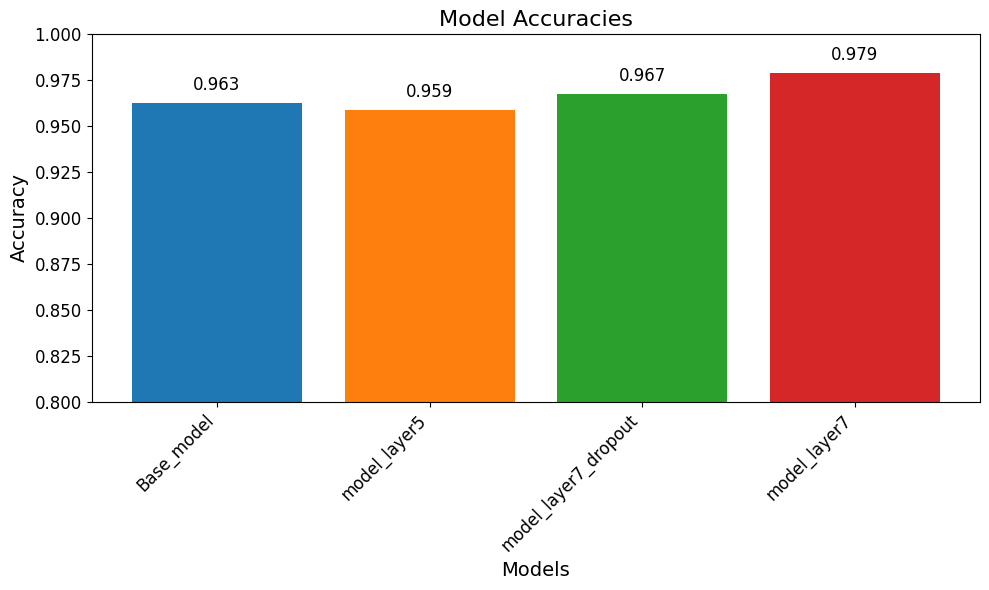

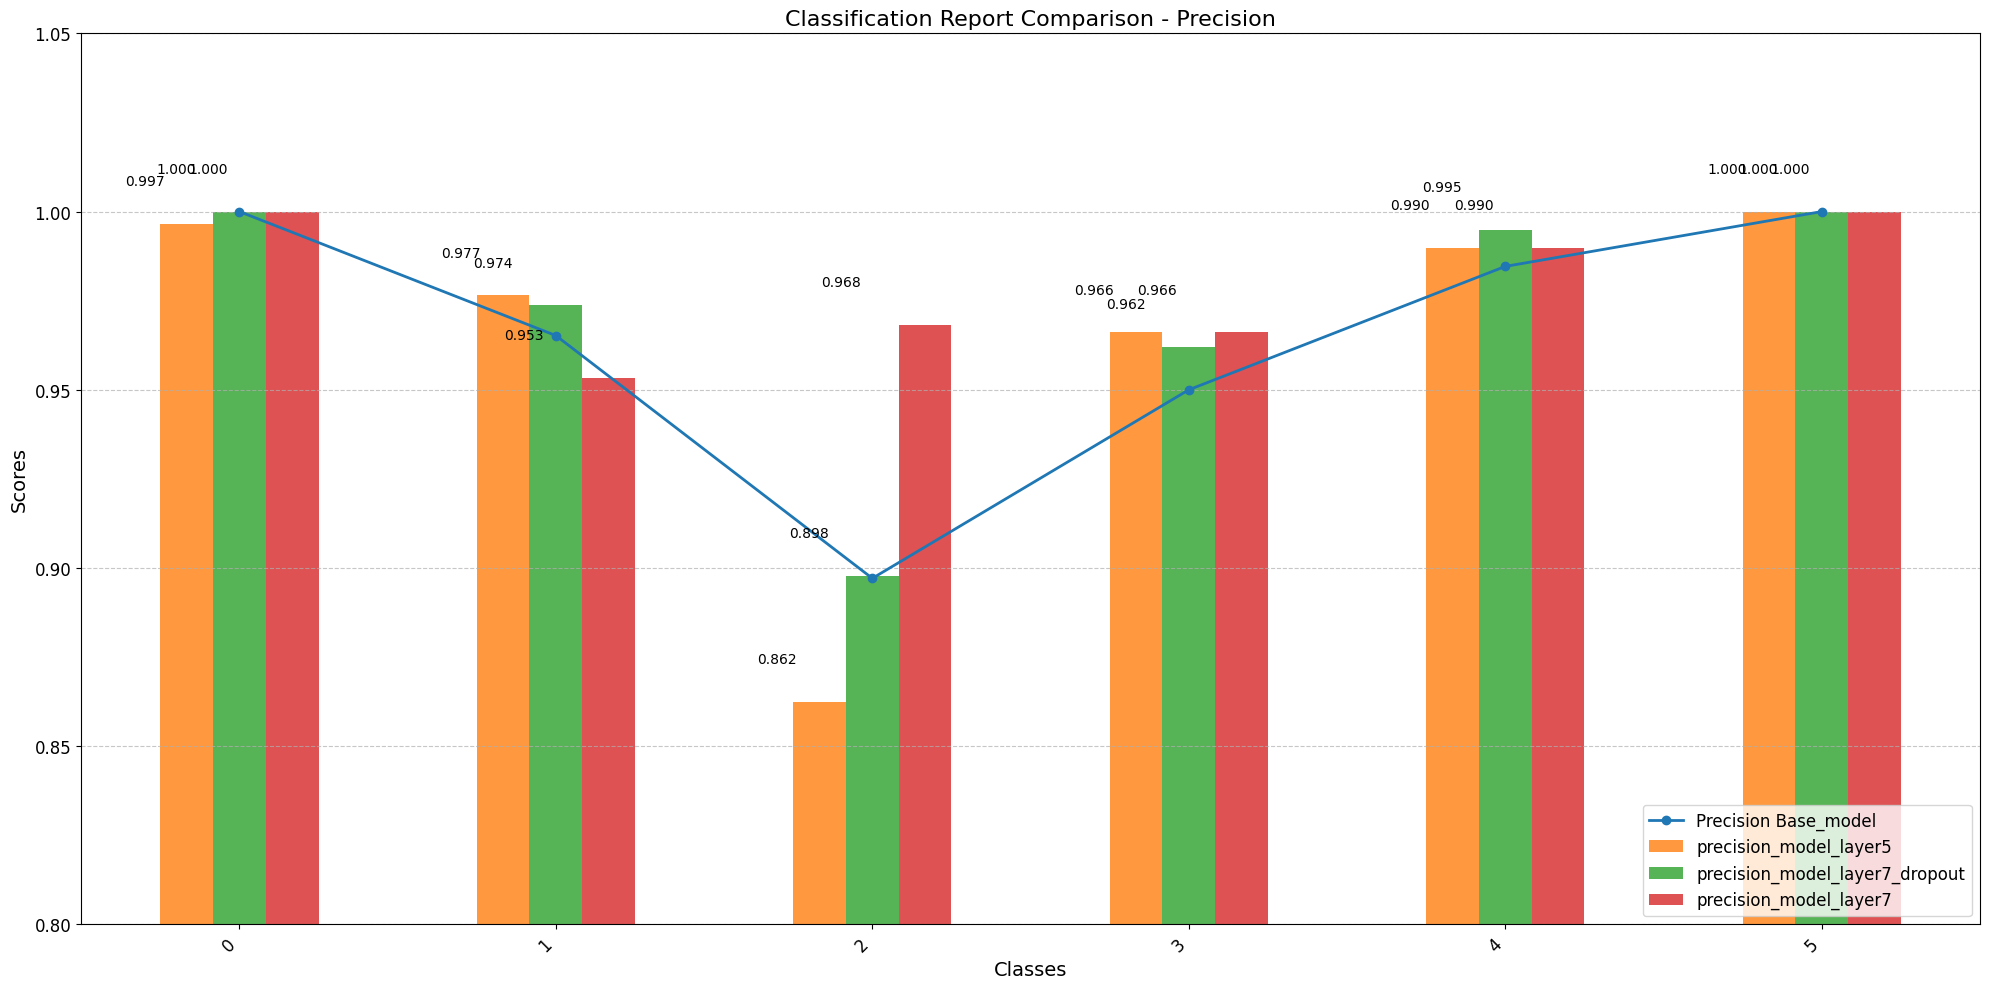

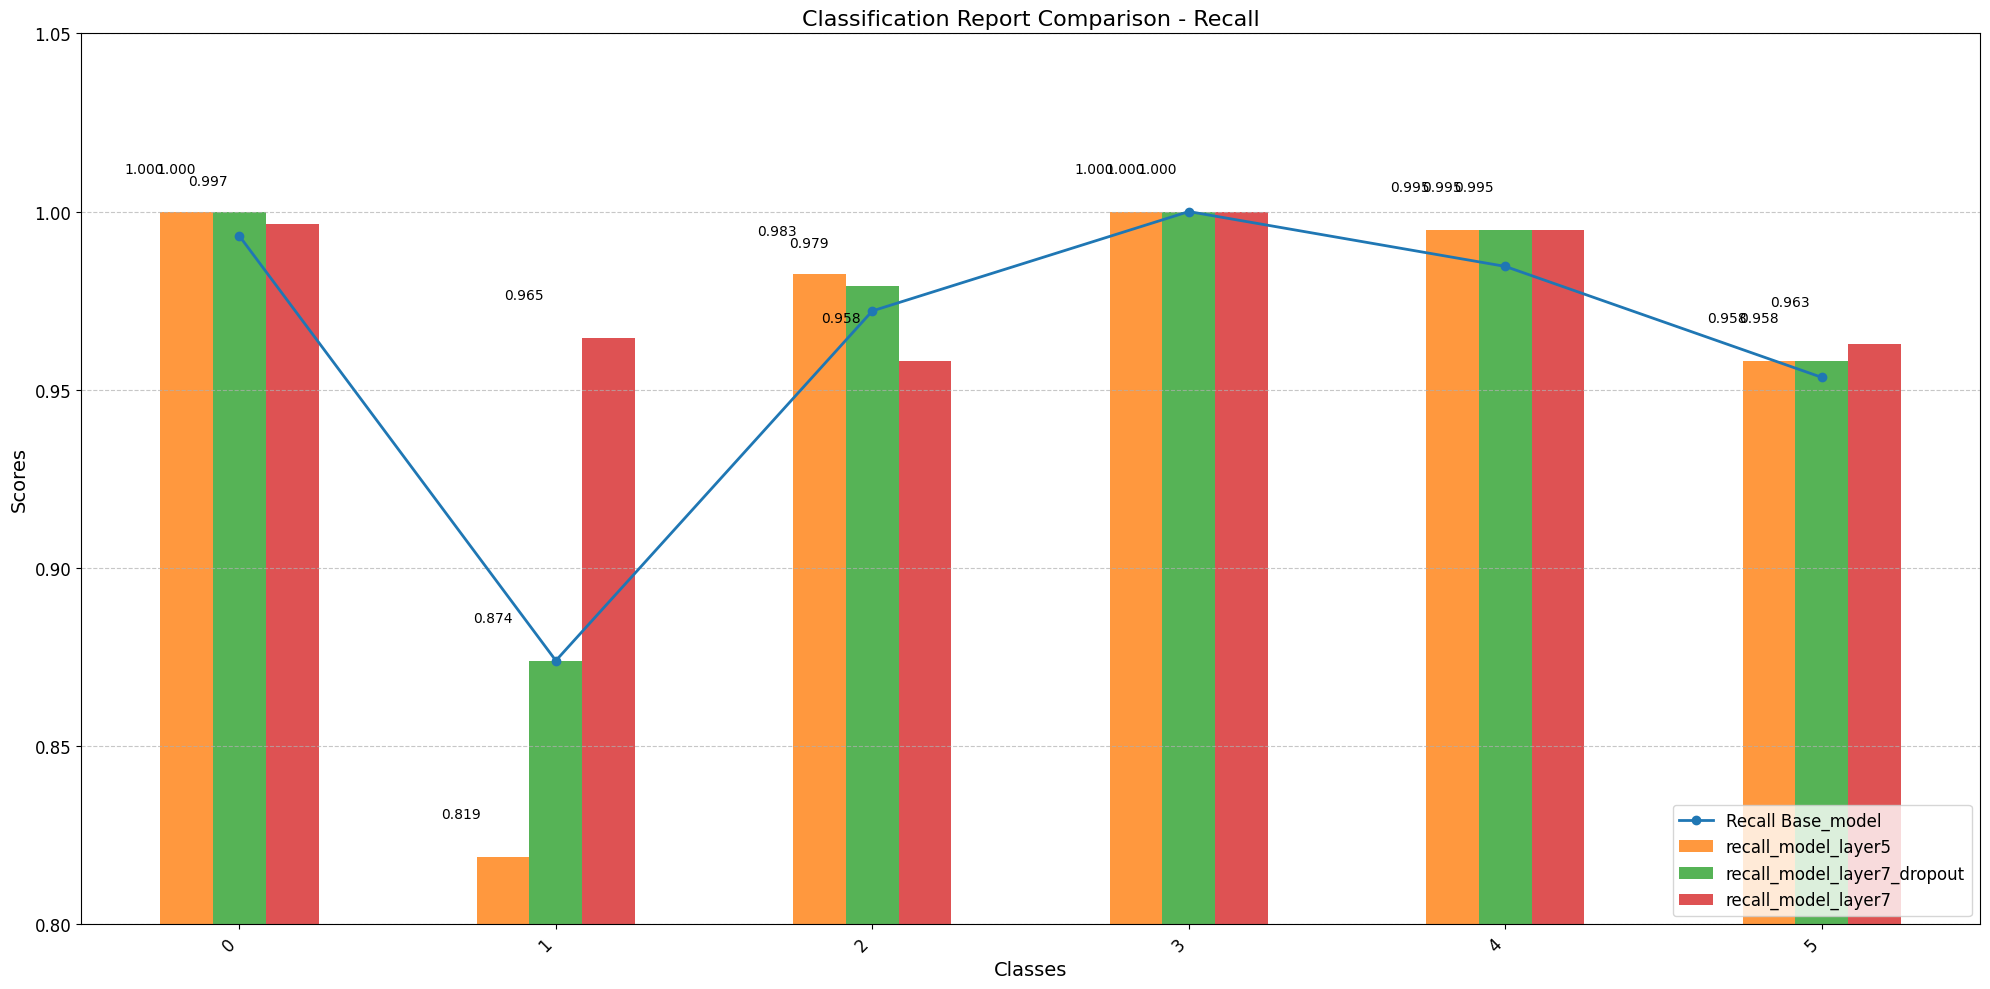

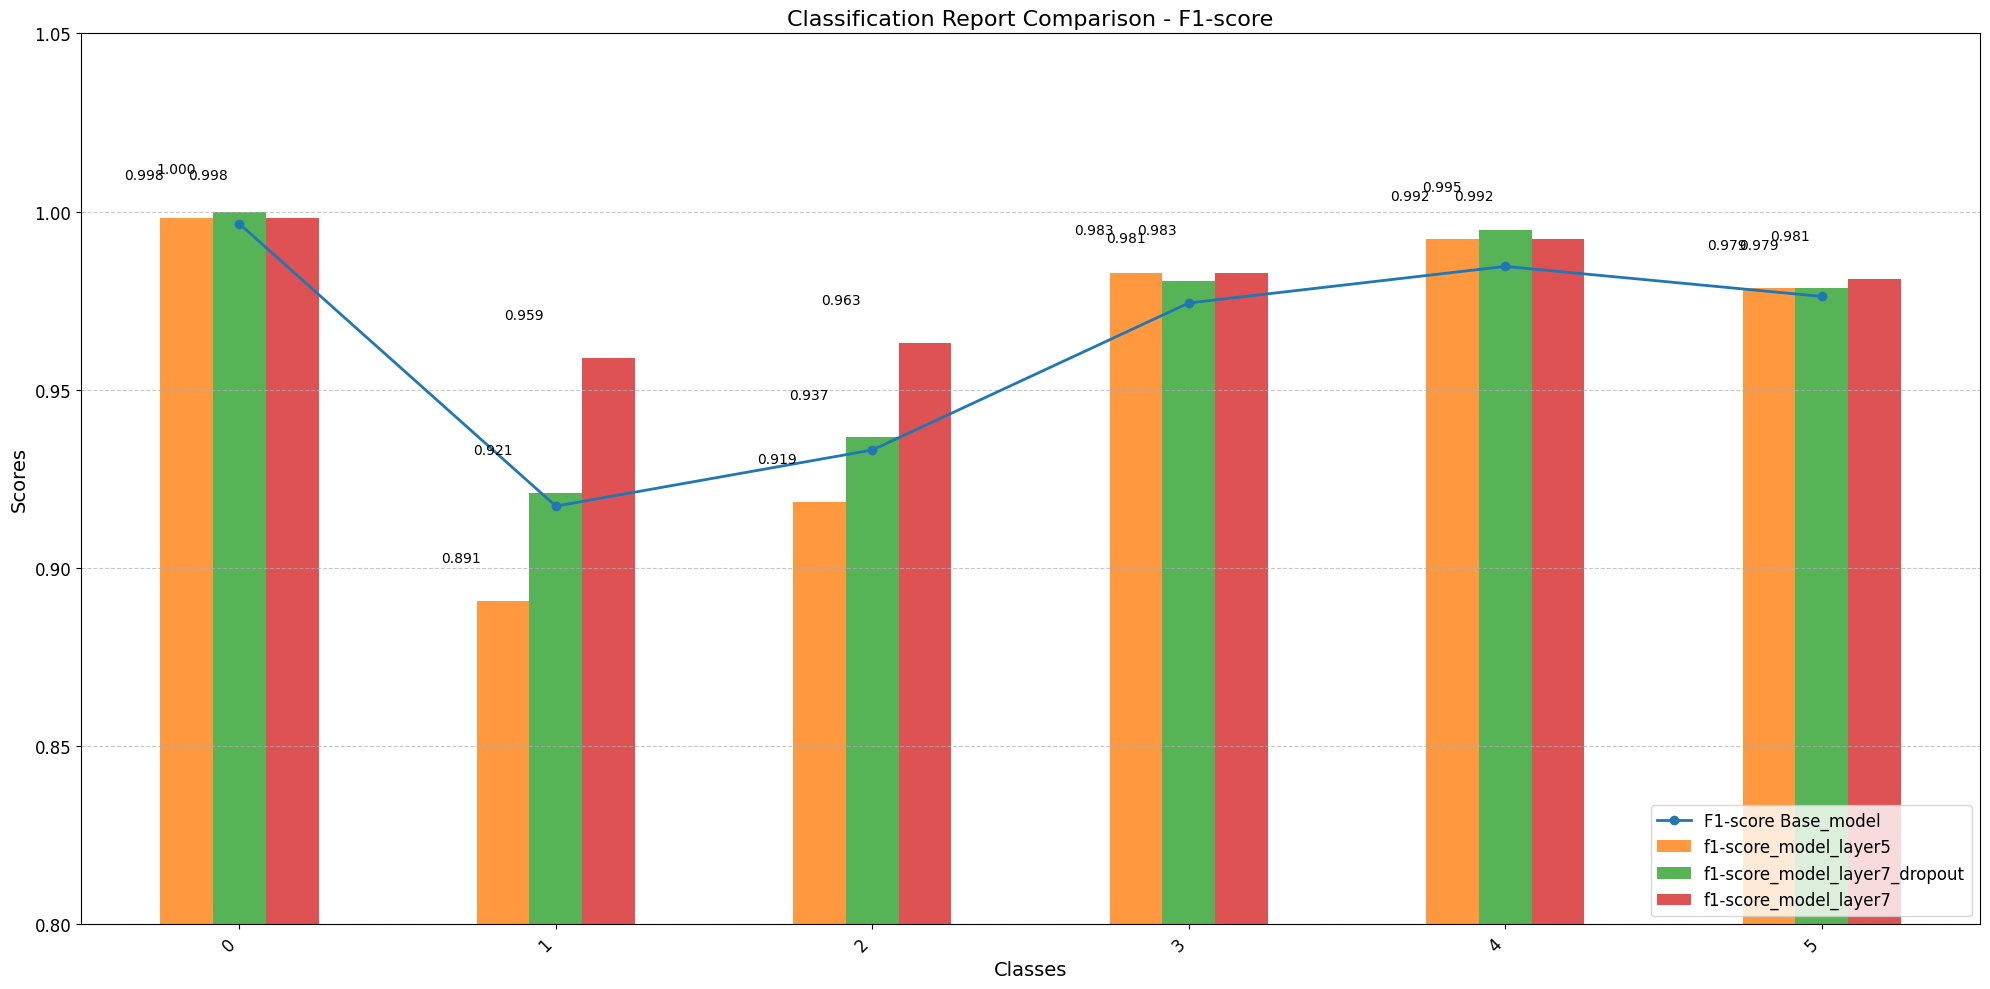

In [ ]:
models = [Base_model, model2, model3, model5]
model_names = ['Base_model', 'model_layer5', 'model_layer7_dropout', 'model_layer7']
compare_classification_reports(models, x, y,model_names, cut_y=True)

In [ ]:
x = data_test.drop('Activity', axis=1)
# ensemble 모델 상위 10개 feature_importance
columns = ['tGravityAcc-min()-X', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-energy()-X', 'tGravityAcc-mean()-Y', 'angle(Y,gravityMean)', 'tGravityAcc-mean()-X', 'tGravityAcc-min()-Y', 'angle(X,gravityMean)', 'tGravityAcc-energy()-Y']
x = x[columns]
y = data_test['Activity']

In [ ]:
from sklearn.preprocessing import LabelEncoder
y =LabelEncoder().fit_transform(y)


28/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

<ipython-input-522-614c79d694af>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('tab10')  # Default colormap


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 1/46 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


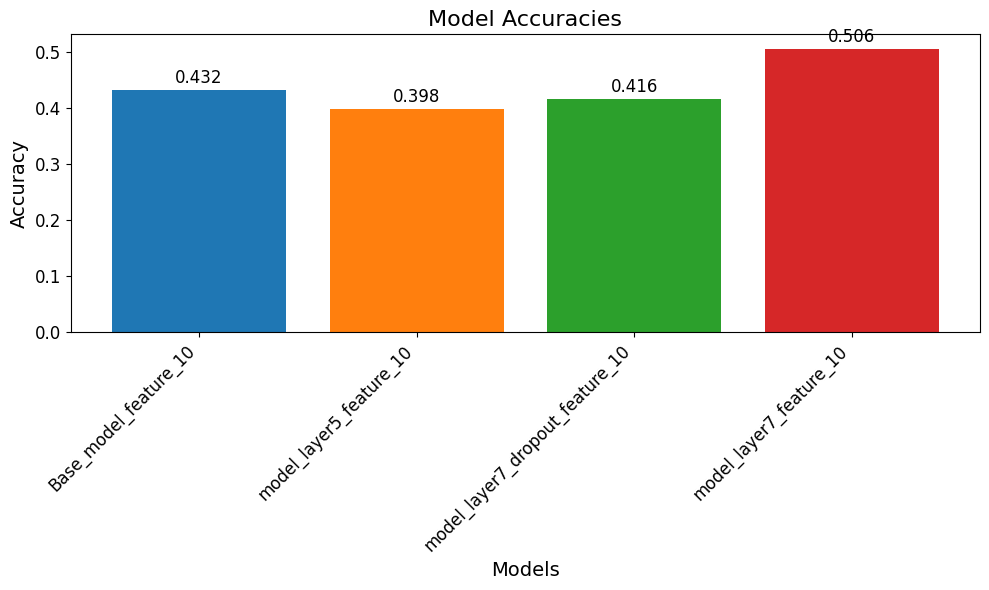

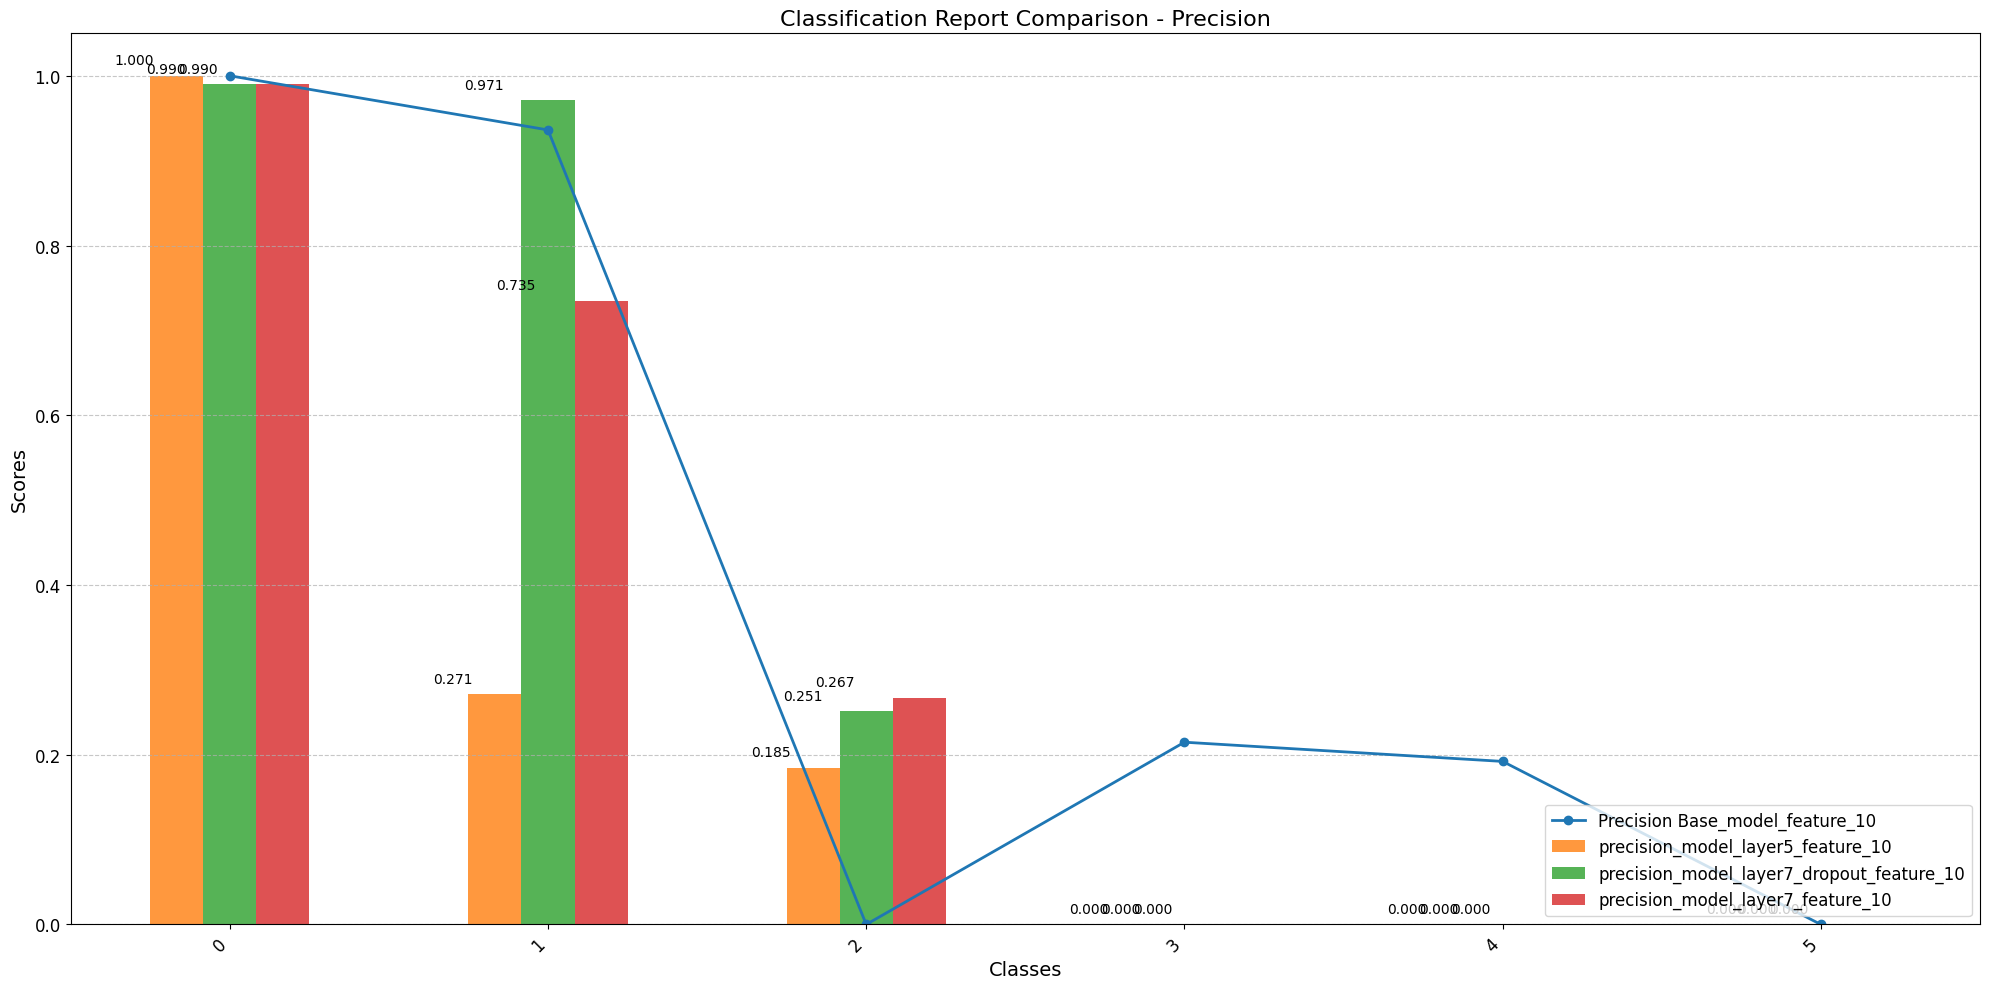

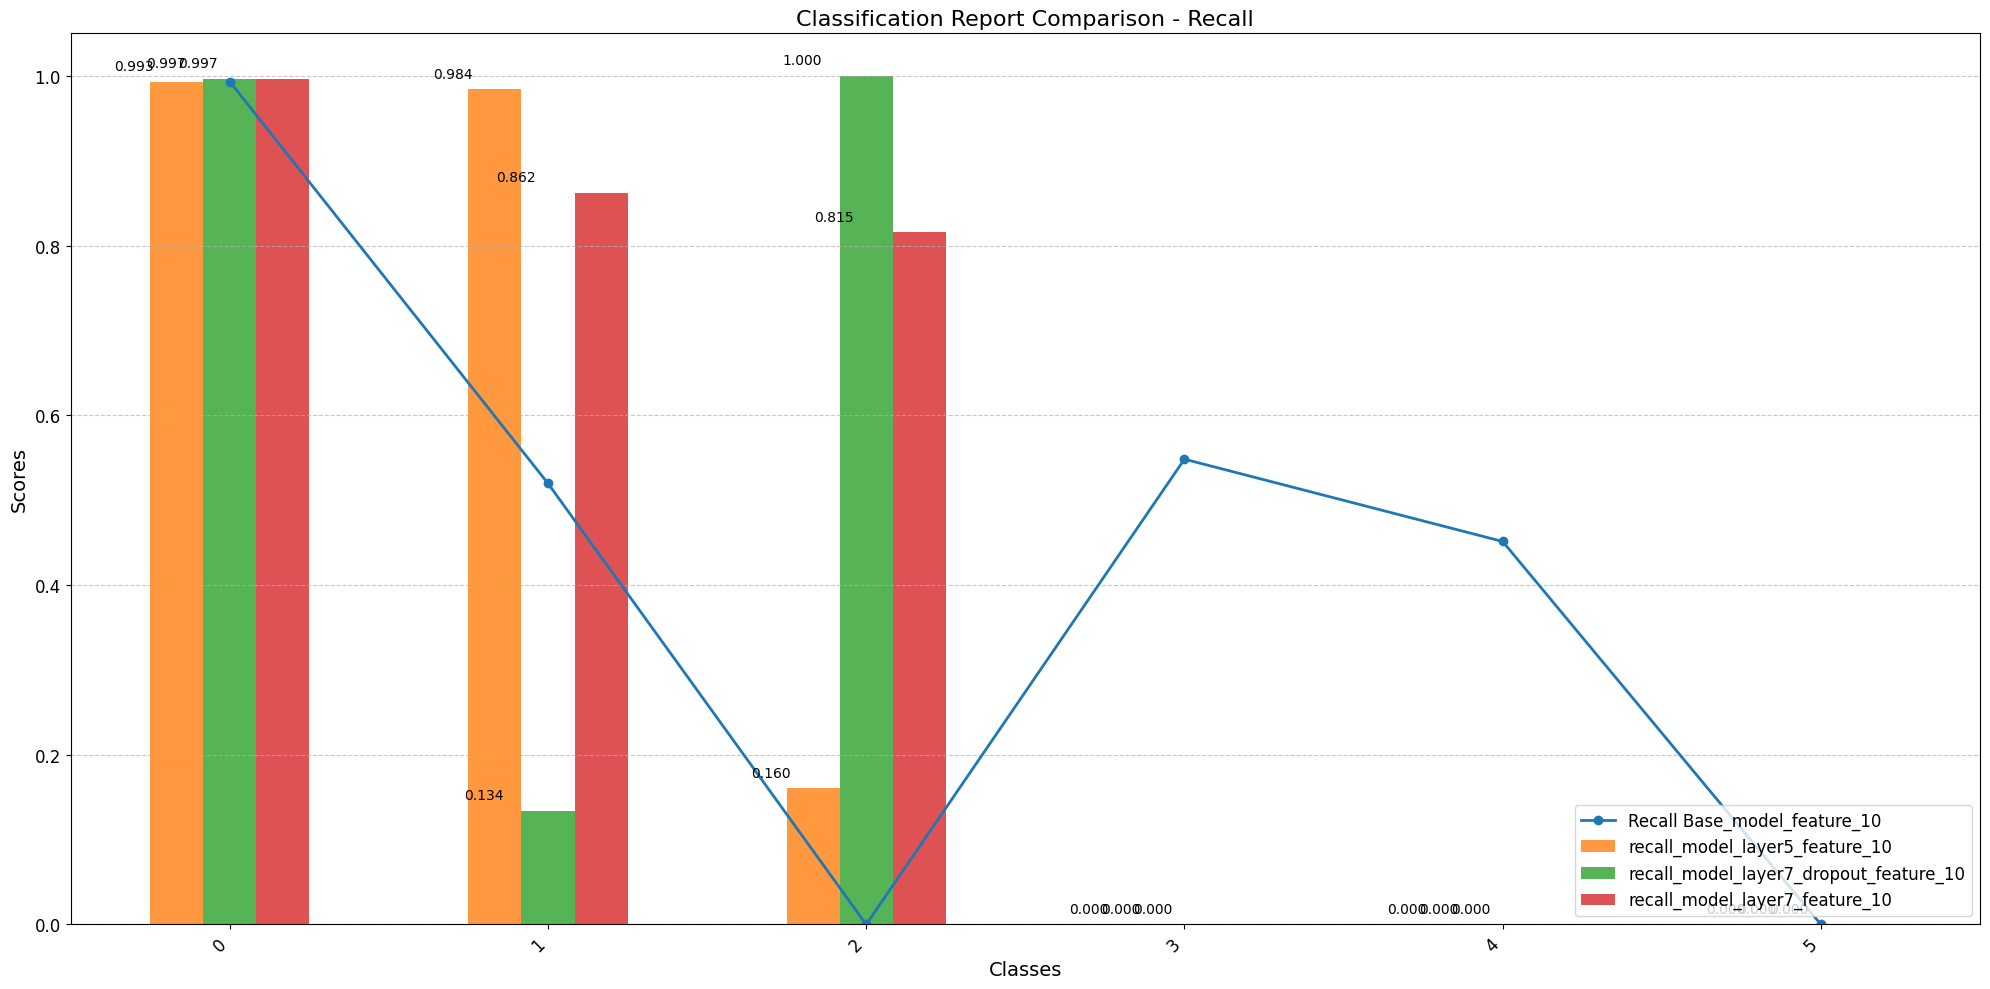

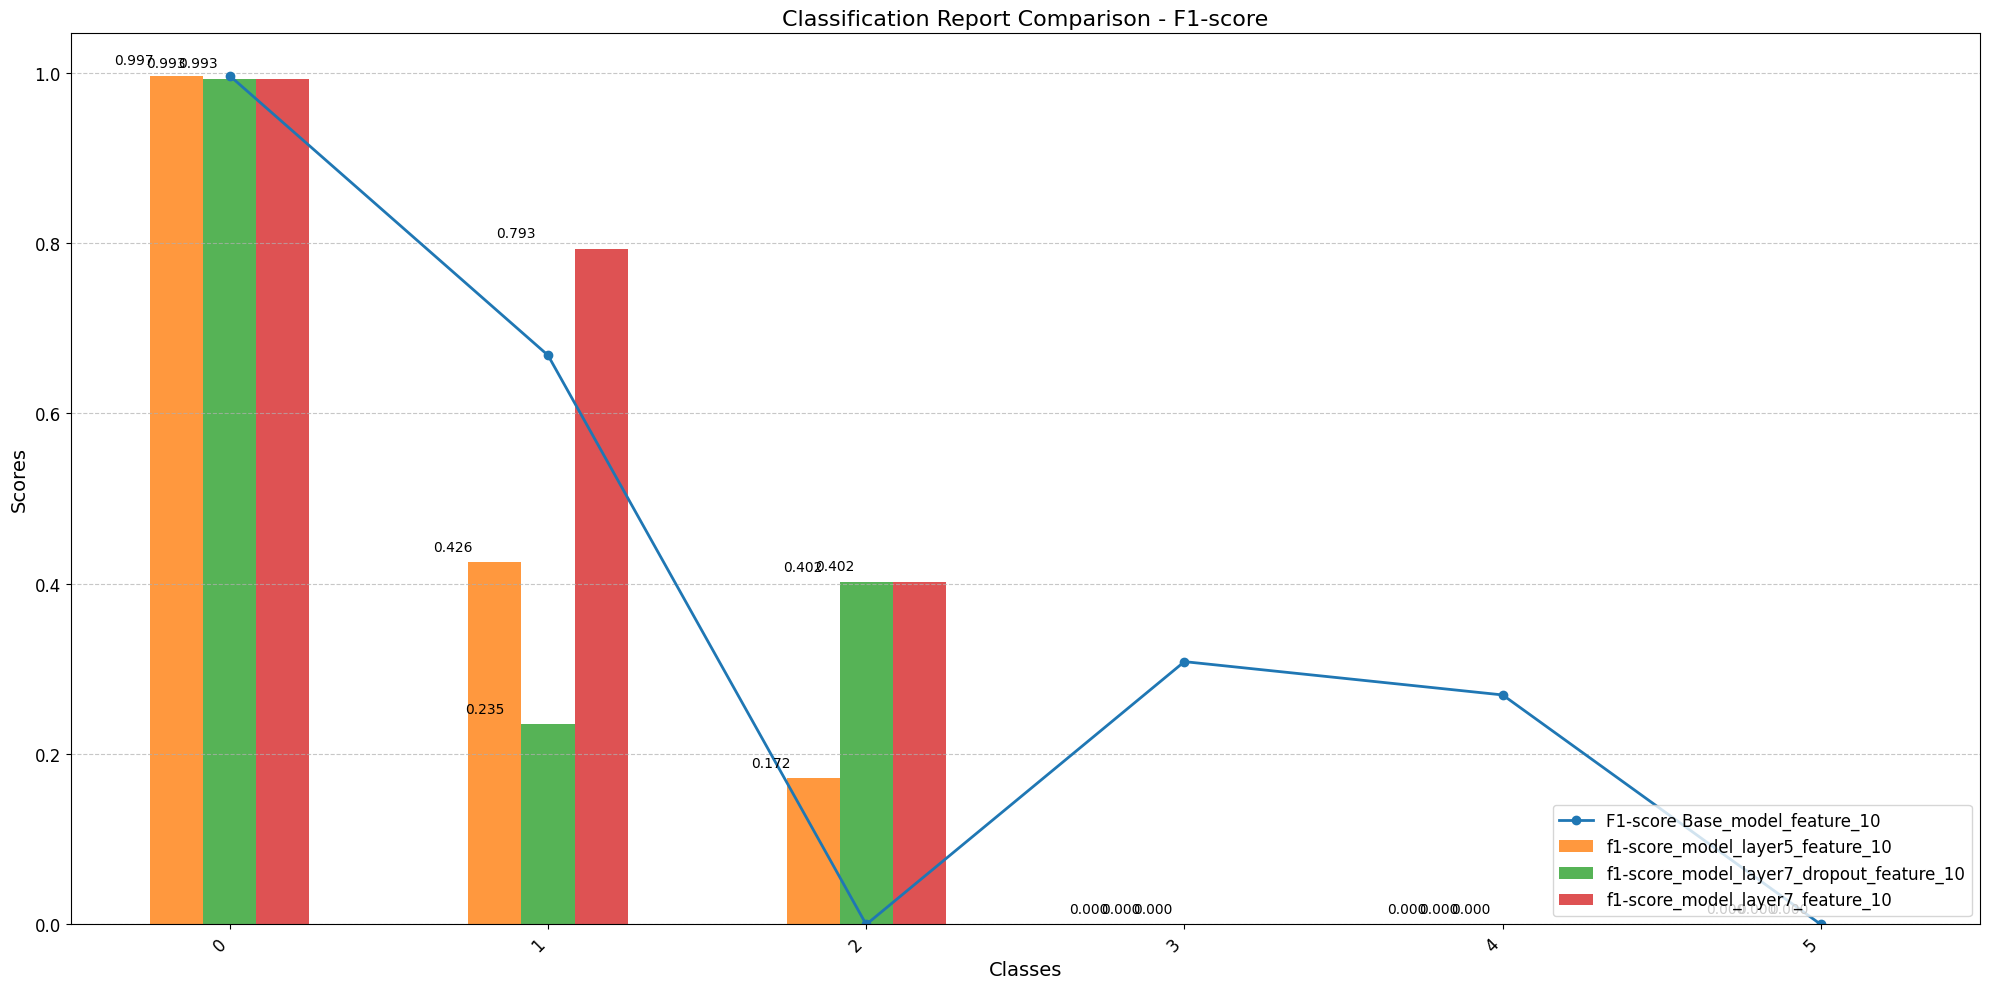

In [ ]:
models = [Base_model, model2, model3, model5]
model_names = ['Base_model_feature_10', 'model_layer5_feature_10', 'model_layer7_dropout_feature_10', 'model_layer7_feature_10']
compare_classification_reports(models, x, y,model_names)